## Set Up

### Google Authorization (Set-up)

In [0]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Dependencies and Imports

In [0]:
import pandas as pd
import numpy as np

import dask.dataframe as dd
import seaborn as sns

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold



In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.utils import to_categorical
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

Using TensorFlow backend.


In [0]:
link = 'https://drive.google.com/open?id=10Ehl5RmxtyJq1rhrlpBsJ5EvhmZN55Qn'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('final_network_sniffing_data.csv')

link = 'https://drive.google.com/open?id=1-LmjWIUNJcA_44tvubiAVg50pQfY5Etd'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('oui.csv')

link = 'https://drive.google.com/open?id=19xZ1yb7rvI9SfFAILGMfKdyWUDH7Ilyh'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('exclude_list.csv')

## Function Definitions

In [0]:
def plot_frame_count(data):
  """
    Plot the frame count against time
  """

  sns.set(rc={'figure.figsize':(50,12)})
  ax = sns.lineplot(x="frame.time", y="count", data=data)
  _ = ax.set_xticklabels(labels=ts_df['frame.time'],rotation=70)

In [0]:
def moving_average(series, n):
  """
    Calculate average of last n observations
  """
  return np.average(series[-n:])

In [0]:
def split_sequence(sequence, n_steps):

  """
    Split a sequence into samples given n_steps
  """
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [0]:
def split_dataframe(data, n_in=1, n_out=1, dropnan=True):

    """
    Split a dataframe
    """

    n_vars = 1 if type(data) is list else data.shape[1]
    # df = pd.DataFrame(data)
    df = data
    cols, names = list(), list()

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
      else:
        names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)

    return agg

In [0]:
def weighted_average(val1, val2):
  """
    Calculate weighted average, giving weight to the smaller value
  """

  weight = 0.8

  if (val1 > val2):
    weighted_avg = (weight*val2 + (1-weight)*val1)
  else:
    weighted_avg = (weight*val1 + (1-weight)*val2)

  return weighted_avg


## Data Exploration and Visualization

In [0]:
## Import network data
df = pd.read_csv('final_network_sniffing_data.csv')
df['frame.time'] = pd.to_datetime(df['frame.time'], format='%Y-%m-%d %H:%M:%S.%f')
df.sort_values(by=['frame.time'], inplace=True)

## Import oui data
oui_df = pd.read_csv('oui.csv')

## Import exclude list
exclude_df = pd.read_csv('exclude_list.csv', header=None)

In [11]:
## View table 
df.dtypes

Unnamed: 0                         int64
frame.number                       int64
frame.time                datetime64[ns]
wlan.addr                         object
wlan.ta                           object
wlan.ra                           object
wlan.sa                           object
wlan.da                           object
wlan.bssid                        object
wlan.fc.type                     float64
wlan.fc.type_subtype             float64
radiotap.channel.freq            float64
radiotap.datarate                float64
radiotap.dbm_antsignal           float64
dtype: object

In [12]:
df.head()

,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal
0,1794769,1,2019-11-03 17:44:59.421161216,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,0.0,8.0,2457.0,1.0,-44.0
1,1794770,2,2019-11-03 17:45:00.427061248,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,0.0,5.0,2457.0,1.0,-44.0
2,1794771,3,2019-11-03 17:45:01.884827392,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,98:fe:94:40:63:4a,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-45.0
3,1794772,4,2019-11-03 17:45:02.697562624,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,0.0,8.0,2457.0,1.0,-46.0
4,1794773,5,2019-11-03 17:45:03.108105728,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,ac:bc:32:9b:0d:fd,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-48.0


In [0]:
##  Extract OUI information from wlan.sa and store in new column
df['wlan.sa oui'] = df['wlan.sa'].str.replace(r':', '').str.slice(stop=6).str.upper()

In [14]:
df.head()

,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,wlan.sa oui
0,1794769,1,2019-11-03 17:44:59.421161216,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,0.0,8.0,2457.0,1.0,-44.0,3497F6
1,1794770,2,2019-11-03 17:45:00.427061248,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,0.0,5.0,2457.0,1.0,-44.0,3497F6
2,1794771,3,2019-11-03 17:45:01.884827392,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,98:fe:94:40:63:4a,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-45.0,98FE94
3,1794772,4,2019-11-03 17:45:02.697562624,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,0.0,8.0,2457.0,1.0,-46.0,3497F6
4,1794773,5,2019-11-03 17:45:03.108105728,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,ac:bc:32:9b:0d:fd,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-48.0,ACBC32


In [15]:
oui_df

,Registry,Assignment,Organization Name,Organization Address
0,MA-L,002272,American Micro-Fuel Device Corp.,2181 Buchanan Loop Ferndale WA US 98248
1,MA-L,00D0EF,IGT,9295 PROTOTYPE DRIVE RENO NV US 89511
2,MA-L,086195,Rockwell Automation,1 Allen-Bradley Dr. Mayfield Heights OH US 441...
3,MA-L,F4BD9E,"Cisco Systems, Inc",80 West Tasman Drive San Jose CA US 94568
4,MA-L,5885E9,Realme Chongqing MobileTelecommunications Corp...,"No.24 Nichang Boulevard, Huixing Block, Yubei ..."
...,...,...,...,...
27128,MA-L,1039E9,Juniper Networks,1133 Innovation Way Sunnyvale CA US 94089
27129,MA-L,309048,"Apple, Inc.",1 Infinite Loop Cupertino CA US 95014
27130,MA-L,D41F0C,JAI Manufacturing,2960-14 Uenojo Nishikata Kushima Miyazaki JP 8...
27131,MA-L,C8FA84,Trusonus corp.,"6F., No.42, Songjiang Rd., Zhongshan Dist Taip..."


In [0]:
##  Merge the network + OUI dataframes
df = df.merge(oui_df, how='inner', left_on='wlan.sa oui', right_on='Assignment')
df = df.drop(columns=['wlan.sa oui', 'Registry', 'Assignment', 'Organization Address'])

In [17]:
df.head()

,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,Organization Name
0,1794769,1,2019-11-03 17:44:59.421161216,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,0.0,8.0,2457.0,1.0,-44.0,ASUSTek COMPUTER INC.
1,1794770,2,2019-11-03 17:45:00.427061248,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,0.0,5.0,2457.0,1.0,-44.0,ASUSTek COMPUTER INC.
2,1794772,4,2019-11-03 17:45:02.697562624,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,0.0,8.0,2457.0,1.0,-46.0,ASUSTek COMPUTER INC.
3,1794780,12,2019-11-03 17:45:14.926533120,b8:27:eb:eb:82:f4,34:97:f6:ac:9c:10,b8:27:eb:eb:82:f4,34:97:f6:ad:0c:f0,b8:27:eb:eb:82:f4,34:97:f6:ac:9c:10,2.0,40.0,2457.0,2.0,-42.0,ASUSTek COMPUTER INC.
4,1794784,16,2019-11-03 17:45:41.071066368,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,90:f1:aa:8d:17:49,34:97:f6:ac:9c:10,0.0,5.0,2457.0,1.0,-43.0,ASUSTek COMPUTER INC.


In [0]:
ts_df = pd.DataFrame(df.groupby(df['frame.time'].dt.strftime('%Y-%m-%d %H')).size())
ts_df.reset_index(inplace=True)
ts_df.columns = ['frame.time','count']

In [19]:
ts_df

,frame.time,count
0,2019-11-03 17,479
1,2019-11-03 18,2587
2,2019-11-03 19,2677
3,2019-11-03 20,4298
4,2019-11-03 21,2406
...,...,...
286,2019-11-15 15,3435
287,2019-11-15 16,2645
288,2019-11-15 17,2549
289,2019-11-15 18,4600


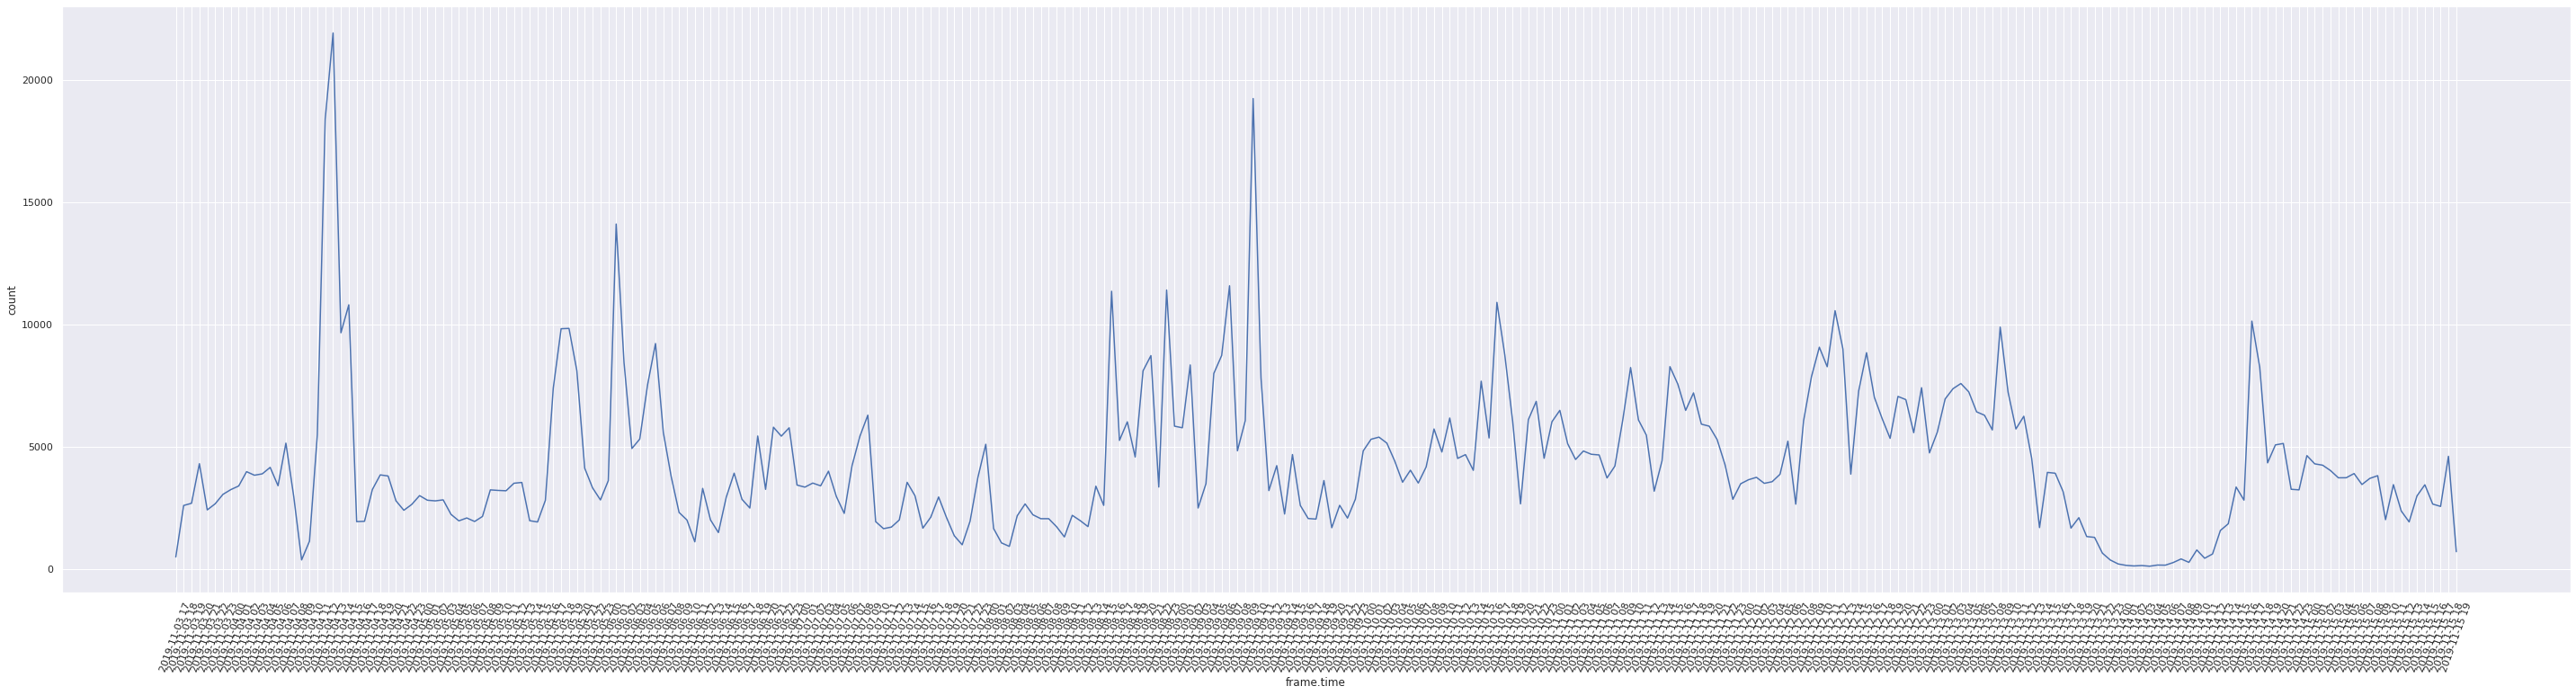

In [20]:
## Plot the raw data
plot_frame_count(ts_df)

In [0]:
sa = df.groupby(['wlan.sa']).size()
sa_df = pd.DataFrame(sa).reset_index()
sa_df.columns = ['wlan.sa', 'count']

In [0]:
sa_df.sort_values(by='count', ascending=False, inplace=True)

In [23]:
sa_df.head(30)

,wlan.sa,count
408,34:97:f6:ac:9c:10,811064
1350,90:f1:aa:8d:17:49,98010
1695,b8:27:eb:eb:82:f4,41541
9,00:06:c7:1f:ea:c7,33438
1853,c4:73:1e:1f:b9:af,25720
153,10:d0:7a:a7:3b:20,17453
1852,c4:2a:d0:de:9a:bd,12577
947,6c:71:d9:90:69:9b,11168
412,34:97:f6:ad:0c:f0,10194
2002,d0:c5:f3:bb:4d:ed,8637


In [24]:
for i in range(0,10):
  df = df[df['wlan.sa'] != sa_df['wlan.sa'].iloc[i]]

exclude_df.columns = ['ip','mac','hostname','company','dnsname','garbage','garbage','garbage']
exclude_df.head()


,ip,mac,hostname,company,dnsname,garbage,garbage,garbage
0,192.168.11.100,84:f3:eb:4a:d4:54,grinder.nyuad.io,Espressif Inc.,grinder.nyuad.io,NaN,NaN,NaN
1,192.168.11.88,00:80:2f:13:54:5f,cloudey-08,NATIONAL INSTRUMENTS CORP.,cloudey-08.nyuad.io,cloudey-08,NaN,NaN
2,192.168.11.87,00:80:2f:13:f5:96,cloudey-07,NATIONAL INSTRUMENTS CORP.,cloudey-07.nyuad.io,cloudey-07,NaN,NaN
3,192.168.11.85,00:80:2f:13:f5:72,cloudey-05,NATIONAL INSTRUMENTS CORP.,cloudey-05.nyuad.io,cloudey-05,NaN,NaN
4,192.168.11.84,00:80:2f:13:f5:6c,cloudey-04,NATIONAL INSTRUMENTS CORP.,cloudey-04.nyuad.io,cloudey-04,NaN,NaN


In [0]:
df = df[~df['wlan.sa'].isin(exclude_df['mac'])]

In [26]:
df

,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,Organization Name
5364,609511,1404,2019-11-04 11:41:11.232932608,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:9c:14,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-36.0,ASUSTek COMPUTER INC.
5406,609565,1458,2019-11-04 11:41:25.057912576,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:9c:14,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-37.0,ASUSTek COMPUTER INC.
10112,621434,4694,2019-11-04 12:06:30.895885568,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:9c:14,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-37.0,ASUSTek COMPUTER INC.
19681,494305,1971,2019-11-04 12:51:04.261702400,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:96:03:24,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-36.0,ASUSTek COMPUTER INC.
19775,494411,2077,2019-11-04 12:51:15.556263936,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:d1:a4,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-35.0,ASUSTek COMPUTER INC.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270109,1021719,1557,2019-11-15 15:37:11.422957312,ff:ff:ff:ff:ff:ff,e0:2c:b2:f2:df:09,ff:ff:ff:ff:ff:ff,e0:2c:b2:f2:df:09,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,0.0,4.0,2457.0,1.0,-82.0,Lenovo Mobile Communication (Wuhan) Company Li...
1270110,1022749,2587,2019-11-15 15:47:31.482262528,ff:ff:ff:ff:ff:ff,ec:d0:9f:fe:cf:1b,ff:ff:ff:ff:ff:ff,ec:d0:9f:fe:cf:1b,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,0.0,4.0,2457.0,1.0,-87.0,Xiaomi Communications Co Ltd
1270111,1839290,1780,2019-11-15 18:30:03.107739392,ff:ff:ff:ff:ff:ff,98:e8:fa:ce:e1:8c,ff:ff:ff:ff:ff:ff,98:e8:fa:ce:e1:8c,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,0.0,4.0,2457.0,1.0,-51.0,"Nintendo Co.,Ltd"
1270112,1839858,2348,2019-11-15 18:40:14.683770880,ff:ff:ff:ff:ff:ff,98:e8:fa:ce:e1:8c,ff:ff:ff:ff:ff:ff,98:e8:fa:ce:e1:8c,ff:ff:ff:ff:ff:ff,ff:ff:ff:ff:ff:ff,0.0,4.0,2457.0,1.0,-46.0,"Nintendo Co.,Ltd"


In [0]:
ts_df = pd.DataFrame(df.groupby(df['frame.time'].dt.strftime('%Y-%m-%d %H')).size())
ts_df.reset_index(inplace=True)
ts_df.columns = ['frame.time','count']

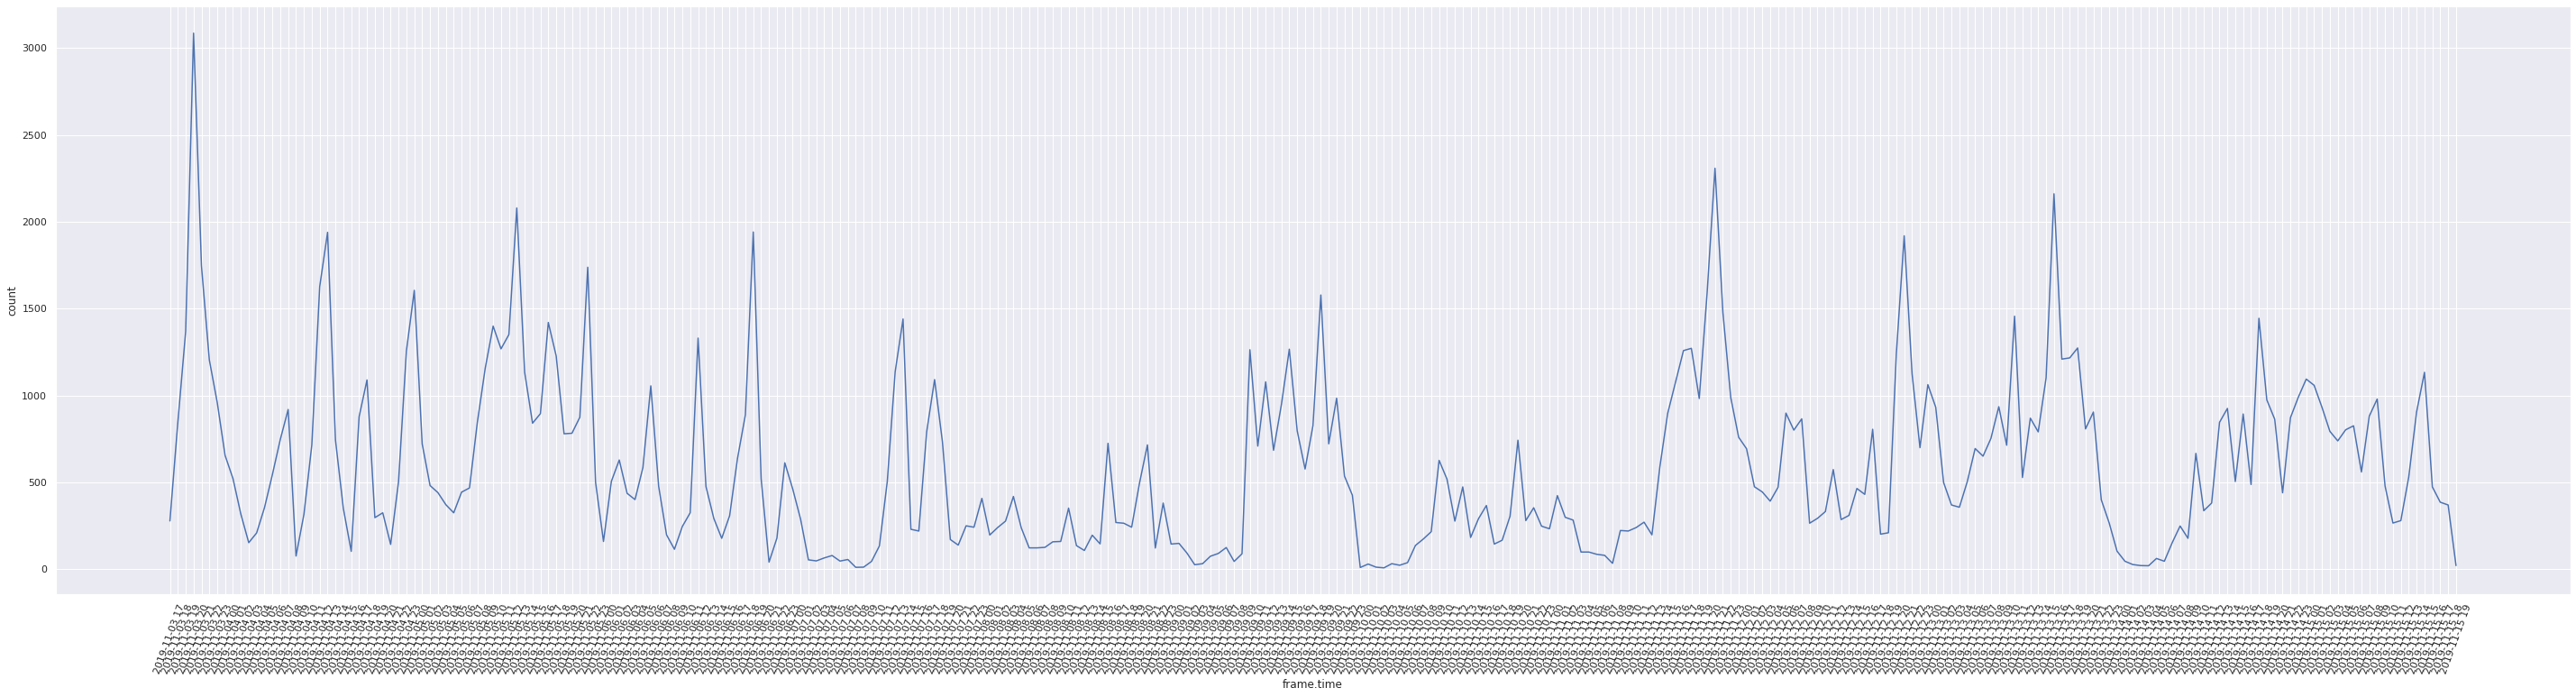

In [28]:
plot_frame_count(ts_df)

## Data Engineering and Consideration

So far the model only has information about the past frame data. We can supplement the model by adding more features:

*   Weekday/Weekend
*   Hour of the Day
*   Day of the Week

We may also improve the accuracy of our model if we input scaled data into the model as well as one hot encode all categorical values

Moreover, we note that there is a relatively large discrepancy in frame count trend on the first and last day as data collection was not run for the full hour. This may seriously affect our model evaluation



### Updating the Original Dataframe

In [29]:
df.head()

,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,Organization Name
5364,609511,1404,2019-11-04 11:41:11.232932608,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:9c:14,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-36.0,ASUSTek COMPUTER INC.
5406,609565,1458,2019-11-04 11:41:25.057912576,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:9c:14,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-37.0,ASUSTek COMPUTER INC.
10112,621434,4694,2019-11-04 12:06:30.895885568,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:9c:14,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-37.0,ASUSTek COMPUTER INC.
19681,494305,1971,2019-11-04 12:51:04.261702400,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:96:03:24,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-36.0,ASUSTek COMPUTER INC.
19775,494411,2077,2019-11-04 12:51:15.556263936,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,01:40:96:ff:ff:00,34:97:f6:ac:d1:a4,01:40:96:ff:ff:00,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-35.0,ASUSTek COMPUTER INC.


In [30]:
## Resort by Date
df.sort_values(by=['frame.time'], inplace=True, ascending=True)
df.reset_index(inplace=True)
df.head()

,index,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,Organization Name
0,821726,1794771,3,2019-11-03 17:45:01.884827392,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,98:fe:94:40:63:4a,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-45.0,"Apple, Inc."
1,823321,1794773,5,2019-11-03 17:45:03.108105728,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,ac:bc:32:9b:0d:fd,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-48.0,"Apple, Inc."
2,823322,1794774,6,2019-11-03 17:45:03.620945920,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,ac:bc:32:9b:0d:fd,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-44.0,"Apple, Inc."
3,824430,1794777,9,2019-11-03 17:45:07.726386432,33:33:00:01:00:03,34:97:f6:ac:9c:10,33:33:00:01:00:03,14:4f:8a:25:27:6d,33:33:00:01:00:03,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-43.0,Intel Corporate
4,824431,1794778,10,2019-11-03 17:45:09.974172416,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,14:4f:8a:25:27:6d,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-45.0,Intel Corporate


In [31]:
##  Add weekday column
df['dayOfWeek'] = df['frame.time'].dt.weekday

##  Add boolean for whether it is weekday or not
df.loc[df['dayOfWeek']<5, 'weekdayBool'] = True
df.loc[df['dayOfWeek']>=5, 'weekdayBool'] = False

df['weekdayBool'] = df['weekdayBool'].astype(int)

##  Add column to store hour of the day
df['hourOfDay'] = df['frame.time'].dt.hour

df.head()

,index,Unnamed: 0,frame.number,frame.time,wlan.addr,wlan.ta,wlan.ra,wlan.sa,wlan.da,wlan.bssid,wlan.fc.type,wlan.fc.type_subtype,radiotap.channel.freq,radiotap.datarate,radiotap.dbm_antsignal,Organization Name,dayOfWeek,weekdayBool,hourOfDay
0,821726,1794771,3,2019-11-03 17:45:01.884827392,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,98:fe:94:40:63:4a,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-45.0,"Apple, Inc.",6,0,17
1,823321,1794773,5,2019-11-03 17:45:03.108105728,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,ac:bc:32:9b:0d:fd,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-48.0,"Apple, Inc.",6,0,17
2,823322,1794774,6,2019-11-03 17:45:03.620945920,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,01:00:5e:00:00:fb,ac:bc:32:9b:0d:fd,01:00:5e:00:00:fb,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-44.0,"Apple, Inc.",6,0,17
3,824430,1794777,9,2019-11-03 17:45:07.726386432,33:33:00:01:00:03,34:97:f6:ac:9c:10,33:33:00:01:00:03,14:4f:8a:25:27:6d,33:33:00:01:00:03,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-43.0,Intel Corporate,6,0,17
4,824431,1794778,10,2019-11-03 17:45:09.974172416,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,ff:ff:ff:ff:ff:ff,14:4f:8a:25:27:6d,ff:ff:ff:ff:ff:ff,34:97:f6:ac:9c:10,2.0,32.0,2457.0,1.0,-45.0,Intel Corporate,6,0,17


### Creating the Dataframe for Frame Count Model

In [0]:
##  Recreate the ts_df, which will eventually be used to create training and testing data
ts_df = pd.DataFrame(df.groupby(df['frame.time'].dt.strftime('%Y-%m-%d %H')).size())
ts_df.reset_index(inplace=True)
ts_df.columns = ['frame.time','count']

ts_df_datetime = pd.to_datetime(ts_df['frame.time'])

##  Add weekday column
ts_df['dayOfWeek'] = ts_df_datetime.dt.weekday

##  Add boolean for whether it is weekday or not
ts_df['weekdayBool'] = False
ts_df.loc[(ts_df['dayOfWeek'] == 4) | (ts_df['dayOfWeek'] == 5), 'weekdayBool'] = True

ts_df['weekdayBool'] = ts_df['weekdayBool'].astype(int)

##  Add column to store hour of the day
ts_df['hourOfDay'] = ts_df_datetime.dt.hour

In [33]:
ts_df

,frame.time,count,dayOfWeek,weekdayBool,hourOfDay
0,2019-11-03 17,277,6,0,17
1,2019-11-03 18,842,6,0,18
2,2019-11-03 19,1369,6,0,19
3,2019-11-03 20,3086,6,0,20
4,2019-11-03 21,1747,6,0,21
...,...,...,...,...,...
286,2019-11-15 15,1133,4,1,15
287,2019-11-15 16,473,4,1,16
288,2019-11-15 17,385,4,1,17
289,2019-11-15 18,369,4,1,18


In [0]:
# drop first and last row
ts_df.drop(ts_df.head(1).index, inplace=True)
ts_df.drop(ts_df.tail(1).index, inplace=True)

In [35]:
ts_df

,frame.time,count,dayOfWeek,weekdayBool,hourOfDay
1,2019-11-03 18,842,6,0,18
2,2019-11-03 19,1369,6,0,19
3,2019-11-03 20,3086,6,0,20
4,2019-11-03 21,1747,6,0,21
5,2019-11-03 22,1204,6,0,22
...,...,...,...,...,...
285,2019-11-15 14,905,4,1,14
286,2019-11-15 15,1133,4,1,15
287,2019-11-15 16,473,4,1,16
288,2019-11-15 17,385,4,1,17


In [36]:
## Model requires a dataframe that doesn't have "string" or "object" datatypes
ts_no_time_df = ts_df.drop(columns=['frame.time'])
ts_no_time_df

,count,dayOfWeek,weekdayBool,hourOfDay
1,842,6,0,18
2,1369,6,0,19
3,3086,6,0,20
4,1747,6,0,21
5,1204,6,0,22
...,...,...,...,...
285,905,4,1,14
286,1133,4,1,15
287,473,4,1,16
288,385,4,1,17


In [0]:
## Create one-hot encodings for all categorical values 
one_hot_day = pd.DataFrame(to_categorical(ts_no_time_df['dayOfWeek']), index=ts_no_time_df.index, columns=['d0','d1', 'd2','d3','d4','d5','d6'])
one_hot_wd_we = pd.DataFrame(to_categorical(ts_no_time_df['weekdayBool']), index=ts_no_time_df.index, columns=['we','wd'])
one_hot_hour = pd.DataFrame(to_categorical(ts_no_time_df['hourOfDay']), index=ts_no_time_df.index, columns=['h0','h1','h2','h3','h4','h5','h6','h7','h8','h9','h10','h11','h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23'])

In [0]:
ts_no_time_df = pd.concat([ts_no_time_df, one_hot_day,one_hot_wd_we,one_hot_hour], axis=1, sort=False)

In [0]:
# scaler = StandardScaler()
# ts_no_time_df['count'] = scaler.fit_transform(ts_no_time_df['count'].values.reshape(-1,1))

In [40]:
ts_no_time_df = ts_no_time_df.drop(columns=['dayOfWeek','weekdayBool','hourOfDay'])
ts_no_time_df

,count,d0,d1,d2,d3,d4,d5,d6,we,wd,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
1,842,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1369,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3086,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1747,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1204,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,905,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286,1133,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
287,473,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
288,385,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Make dataset with t-3 upto to t-1 to predict count at t
n_steps_fc = 3
n_features_fc = 34
reframed = split_dataframe(ts_no_time_df , n_steps_fc, 1)
reframed.drop(reframed.columns[-(n_features_fc-1):], axis=1, inplace=True)
reframed

,count(t-3),d0(t-3),d1(t-3),d2(t-3),d3(t-3),d4(t-3),d5(t-3),d6(t-3),we(t-3),wd(t-3),h0(t-3),h1(t-3),h2(t-3),h3(t-3),h4(t-3),h5(t-3),h6(t-3),h7(t-3),h8(t-3),h9(t-3),h10(t-3),h11(t-3),h12(t-3),h13(t-3),h14(t-3),h15(t-3),h16(t-3),h17(t-3),h18(t-3),h19(t-3),h20(t-3),h21(t-3),h22(t-3),h23(t-3),count(t-2),d0(t-2),d1(t-2),d2(t-2),d3(t-2),d4(t-2),...,h19(t-2),h20(t-2),h21(t-2),h22(t-2),h23(t-2),count(t-1),d0(t-1),d1(t-1),d2(t-1),d3(t-1),d4(t-1),d5(t-1),d6(t-1),we(t-1),wd(t-1),h0(t-1),h1(t-1),h2(t-1),h3(t-1),h4(t-1),h5(t-1),h6(t-1),h7(t-1),h8(t-1),h9(t-1),h10(t-1),h11(t-1),h12(t-1),h13(t-1),h14(t-1),h15(t-1),h16(t-1),h17(t-1),h18(t-1),h19(t-1),h20(t-1),h21(t-1),h22(t-1),h23(t-1),count(t)
4,842.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1369.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,3086.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1747
5,1369.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3086.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1747.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1204
6,3086.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1747.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1204.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,960
7,1747.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1204.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,960.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,654
8,1204.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,960.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,654.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,265.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,529.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905
286,279.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,529.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,905.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1133
287,529.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,905.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1133.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,473
288,905.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1133.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,473.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,

### Creating the Dataframe for Unique MAC Model

In [42]:
##  Hourly Address Count into a dataframe
hac_df = pd.DataFrame(df.groupby([df['frame.time'].dt.strftime('%Y-%m-%d %H'),df['wlan.sa']]).size())

##  Unique MACs per Hourly Interval 
umac_df = pd.DataFrame(hac_df.groupby(level=0).size())
umac_df.reset_index(inplace=True)
umac_df.columns = ['frame.time','count']

# drop first and last row
umac_df.drop(umac_df.head(1).index, inplace=True)
umac_df.drop(umac_df.tail(1).index, inplace=True)

umac_df

,frame.time,count
1,2019-11-03 18,51
2,2019-11-03 19,80
3,2019-11-03 20,111
4,2019-11-03 21,59
5,2019-11-03 22,81
...,...,...
285,2019-11-15 14,56
286,2019-11-15 15,73
287,2019-11-15 16,27
288,2019-11-15 17,22


In [43]:
umac_no_time_df = umac_df.drop(columns=['frame.time'])
umac_no_time_df

,count
1,51
2,80
3,111
4,59
5,81
...,...
285,56
286,73
287,27
288,22


In [44]:
n_steps_umac = 3
n_features_umac = 1
umac_reframed = split_dataframe(umac_no_time_df, n_steps_umac, 1)
umac_reframed

,count(t-3),count(t-2),count(t-1),count(t)
4,51.0,80.0,111.0,59
5,80.0,111.0,59.0,81
6,111.0,59.0,81.0,54
7,59.0,81.0,54.0,54
8,81.0,54.0,54.0,36
...,...,...,...,...
285,24.0,24.0,29.0,56
286,24.0,29.0,56.0,73
287,29.0,56.0,73.0,27
288,56.0,73.0,27.0,22


### Creating the Dataframe for "Busyness"

In [0]:
scaler = MinMaxScaler()
ts_df_normalized = ts_df.copy()
umac_df_normalized = umac_df.copy()

ts_df_normalized['count'] = scaler.fit_transform(ts_df_normalized['count'].values.reshape(-1,1))
umac_df_normalized['count'] = scaler.fit_transform(umac_df_normalized['count'].values.reshape(-1,1))

ts_df_normalized['prenorm_count'] = ts_df['count']
umac_df_normalized['prenorm_count'] = umac_df['count']

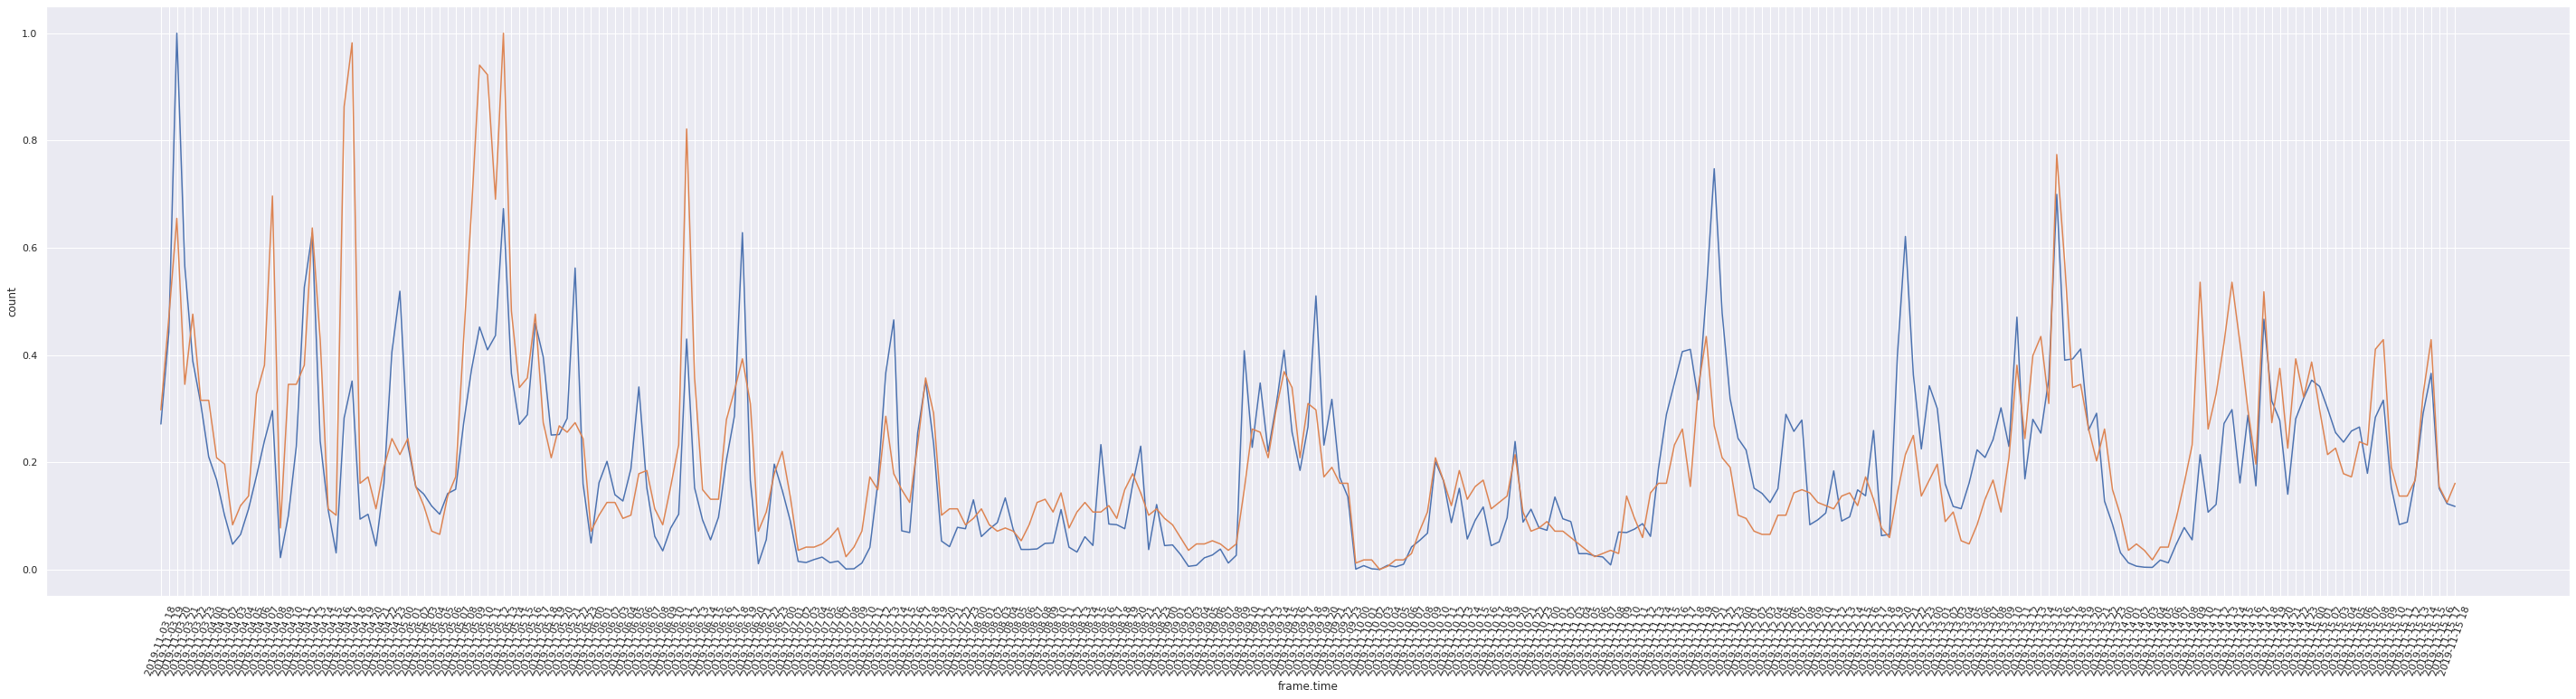

In [46]:
plot_frame_count(ts_df_normalized)
plot_frame_count(umac_df_normalized)

In [47]:
busyness_df = pd.merge(ts_df_normalized[['frame.time','count']], umac_df_normalized['count'], how='inner', left_index=True, right_index=True)
busyness_df.columns = ['frame.time', 'frame.count.normalized', 'umac.count.normalized']

busyness_df['frame.count'] = ts_df_normalized['prenorm_count']
busyness_df['umac.count'] = umac_df_normalized['prenorm_count']
busyness_df

,frame.time,frame.count.normalized,umac.count.normalized,frame.count,umac.count
1,2019-11-03 18,0.271192,0.297619,842,51
2,2019-11-03 19,0.442351,0.470238,1369,80
3,2019-11-03 20,1.000000,0.654762,3086,111
4,2019-11-03 21,0.565119,0.345238,1747,59
5,2019-11-03 22,0.388763,0.476190,1204,81
...,...,...,...,...,...
285,2019-11-15 14,0.291653,0.327381,905,56
286,2019-11-15 15,0.365703,0.428571,1133,73
287,2019-11-15 16,0.151348,0.154762,473,27
288,2019-11-15 17,0.122767,0.125000,385,22


In [48]:
busyness_df['count'] = busyness_df.apply(lambda row: weighted_average(row['frame.count.normalized'], row['umac.count.normalized']), axis = 1)
busyness_df

,frame.time,frame.count.normalized,umac.count.normalized,frame.count,umac.count,count
1,2019-11-03 18,0.271192,0.297619,842,51,0.276477
2,2019-11-03 19,0.442351,0.470238,1369,80,0.447929
3,2019-11-03 20,1.000000,0.654762,3086,111,0.723810
4,2019-11-03 21,0.565119,0.345238,1747,59,0.389214
5,2019-11-03 22,0.388763,0.476190,1204,81,0.406248
...,...,...,...,...,...,...
285,2019-11-15 14,0.291653,0.327381,905,56,0.298799
286,2019-11-15 15,0.365703,0.428571,1133,73,0.378277
287,2019-11-15 16,0.151348,0.154762,473,27,0.152031
288,2019-11-15 17,0.122767,0.125000,385,22,0.123214


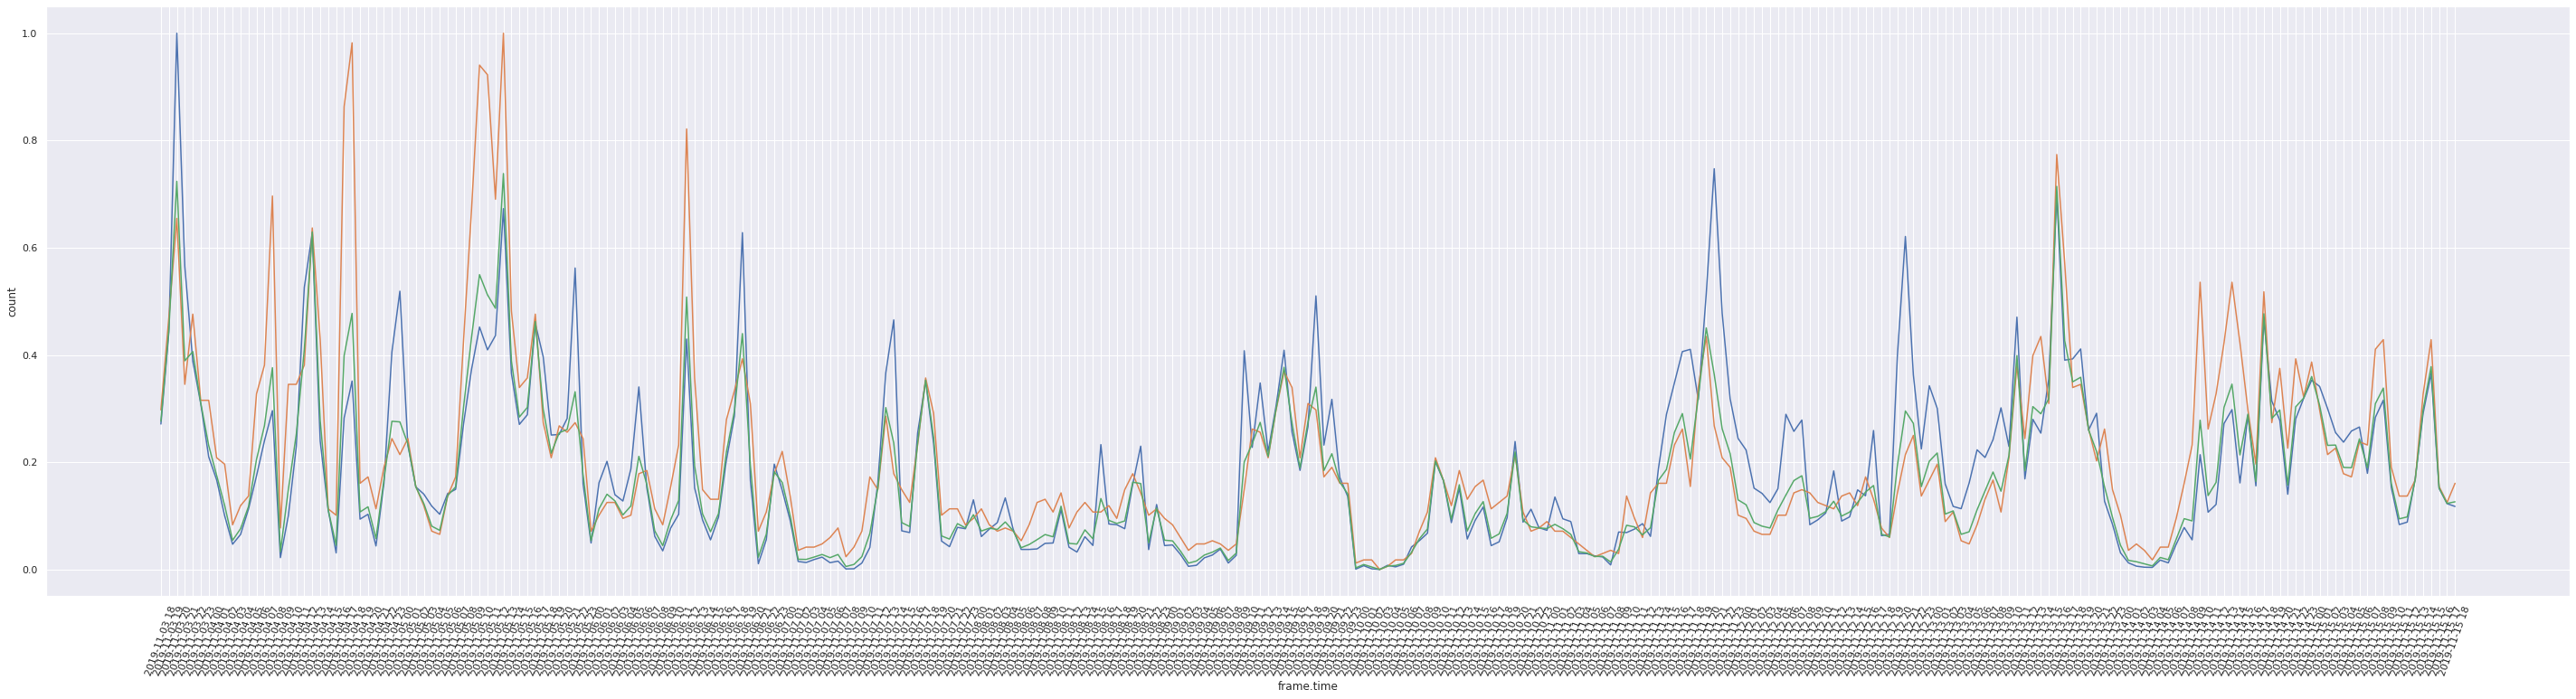

In [49]:
plot_frame_count(ts_df_normalized)
plot_frame_count(umac_df_normalized)
plot_frame_count(busyness_df)

In [50]:
busyness_no_time_df = busyness_df.drop(columns=['frame.time','frame.count.normalized', 'umac.count.normalized'])
busyness_no_time_df

,frame.count,umac.count,count
1,842,51,0.276477
2,1369,80,0.447929
3,3086,111,0.723810
4,1747,59,0.389214
5,1204,81,0.406248
...,...,...,...
285,905,56,0.298799
286,1133,73,0.378277
287,473,27,0.152031
288,385,22,0.123214


## Splitting Data

In [0]:
train_fraction = 0.70

### Splitting into Training and Testing for Frame Count Prediction

In [0]:
values_fc = reframed.values
n_train_hours_fc = int(ts_no_time_df.shape[0]*train_fraction)
train_fc = values_fc[:n_train_hours_fc, :]
test_fc = values_fc[n_train_hours_fc:, :]

In [53]:
n_obs_fc = (n_steps_fc) * n_features_fc
X_train_fc, y_train_fc = train_fc[:, :n_obs_fc], train_fc[:, -1]
X_test_fc, y_test_fc = test_fc[:, :n_obs_fc], test_fc[:, -1]
print(X_train_fc.shape, len(X_train_fc), y_train_fc.shape)

(202, 102) 202 (202,)


In [0]:
# reshape input to be 3D [samples, timesteps, features]
X_train_fc = X_train_fc.reshape((X_train_fc.shape[0], n_steps_fc, n_features_fc))
X_test_fc = X_test_fc.reshape((X_test_fc.shape[0], n_steps_fc, n_features_fc))

In [55]:
print(X_train_fc.shape)
print(X_test_fc.shape)

(202, 3, 34)
(84, 3, 34)


### Splitting into Training and Testing for Frame Count to People Count Relation

In [0]:
values_umac = umac_reframed.values
n_train_hours_umac = int(umac_df.shape[0]*train_fraction)
train_umac = values_umac[:n_train_hours_umac, :]
test_umac = values_umac[n_train_hours_umac:, :]

In [57]:
n_obs_umac = (n_steps_umac)*n_features_umac
X_train_umac, y_train_umac = train_umac[:, :n_obs_umac], train_umac[:, -1]
X_test_umac, y_test_umac = test_umac[:, :n_obs_umac], test_umac[:, -1]
print(X_train_umac.shape, len(X_train_umac), y_train_umac.shape)

(202, 3) 202 (202,)


In [0]:
# reshape input to be 3D [samples, timesteps, features]
X_train_umac = X_train_umac.reshape((X_train_umac.shape[0], n_steps_umac, n_features_umac))
X_test_umac = X_test_umac.reshape((X_test_umac.shape[0], n_steps_umac, n_features_umac))

In [59]:
print(X_train_umac.shape)
print(X_test_umac.shape)

(202, 3, 1)
(84, 3, 1)


### Splitting into Training and Testing for Busyness

In [102]:
X_busyness = busyness_no_time_df[['frame.count','umac.count']]
y_busyness = busyness_no_time_df['count']

X_train_busyness, X_test_busyness, y_train_busyness, y_test_busyness = train_test_split(X_busyness, y_busyness, train_size=train_fraction, random_state=42, shuffle=False)
y_train_busyness

1      0.276477
2      0.447929
3      0.723810
4      0.389214
5      0.406248
         ...   
198    0.216038
199    0.129799
200    0.120750
201    0.087477
202    0.080767
Name: count, Length: 202, dtype: float64

In [61]:
X_train_busyness

,frame.count,umac.count
1,842,51
2,1369,80
3,3086,111
4,1747,59
5,1204,81
...,...,...
198,987,33
199,759,18
200,693,17
201,474,13


In [62]:
X_test_busyness

,frame.count,umac.count
203,391,12
204,471,18
205,898,18
206,800,25
207,865,26
...,...,...
285,905,56
286,1133,73
287,473,27
288,385,22


In [63]:
print(X_train_busyness.shape)
print(X_test_busyness.shape)

print(y_train_busyness.shape)
print(y_test_busyness.shape)

(202, 2)
(87, 2)
(202,)
(87,)


## Functional Model 1

### Model Training

In [0]:
# model = Sequential()
# model.add(LSTM(250, activation='relu', input_shape=((n_steps), n_features), return_sequences=True))
# # model.add(LSTM(250, activation='relu', return_sequences=True))
# model.add(LSTM(250, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

In [0]:
# np.concatenate((y_train_fc.reshape(-1,1), y_train_umac.reshape(-1,1)), axis=1)

In [925]:
n_steps_fc = 3
n_features_fc= 34
n_steps_umac = 3
n_features_umac = 1

##  define input
visible1 = Input(shape=(n_steps_fc, n_features_fc))
##  first interpretation model 
hidden1 = LSTM(250, activation='relu', return_sequences=True, dropout=0.12)(visible1)
hidden2 = LSTM(250, activation='relu', return_sequences=True)(hidden1)
hidden3 = LSTM(250, activation='relu')(hidden2)
frame_count = Dense(1)(hidden3)
##  define output
frame_count_model = Model(visible1, frame_count)

##  define input
visible2 = Input(shape=(n_steps_umac, n_features_umac))
##  second interpretation  model
hidden4 = LSTM(200, activation='relu', return_sequences=True, dropout=0.2)(visible2)
hidden5 = LSTM(200, activation='relu', return_sequences=True)(hidden4)
hidden6 = LSTM(200, activation='relu')(hidden5)
umac_count = Dense(1)(hidden6)
umac_count_model = Model(visible2, umac_count)

model = Model(inputs=[visible1, visible2], outputs=[frame_count,umac_count])
print(model.summary())
model.compile(optimizer='adam', loss='mse')

Model: "model_141"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          (None, 3, 34)        0                                            
__________________________________________________________________________________________________
input_106 (InputLayer)          (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_133 (LSTM)                 (None, 3, 250)       285000      input_105[0][0]                  
__________________________________________________________________________________________________
lstm_136 (LSTM)                 (None, 3, 200)       161600      input_106[0][0]                  
__________________________________________________________________________________________

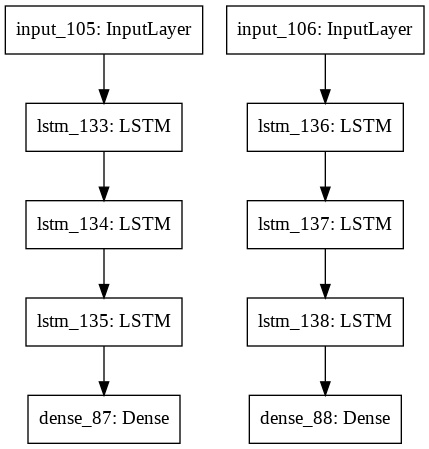

In [926]:
plot_model(model)

In [927]:
      model.fit([X_train_fc, X_train_umac],[y_train_fc, y_train_umac], epochs=200, verbose=1, shuffle=False)

Epoch 1/200
202/202 [==============================] - 34s 170ms/step - loss: 461286.2450 - dense_87_loss: 459306.9920 - dense_88_loss: 1979.2580
Epoch 2/200
202/202 [==============================] - 0s 2ms/step - loss: 295670.9870 - dense_87_loss: 294342.4938 - dense_88_loss: 1328.4962
Epoch 3/200
202/202 [==============================] - 0s 2ms/step - loss: 231691.6231 - dense_87_loss: 229747.0288 - dense_88_loss: 1944.5987
Epoch 4/200
202/202 [==============================] - 0s 2ms/step - loss: 216262.2376 - dense_87_loss: 214945.9771 - dense_88_loss: 1316.2613
Epoch 5/200
202/202 [==============================] - 0s 2ms/step - loss: 220946.6853 - dense_87_loss: 219753.1547 - dense_88_loss: 1193.5281
Epoch 6/200
202/202 [==============================] - 0s 2ms/step - loss: 230864.5873 - dense_87_loss: 229764.6009 - dense_88_loss: 1099.9864
Epoch 7/200
202/202 [==============================] - 0s 2ms/step - loss: 211242.8001 - dense_87_loss: 210120.3348 - dense_88_loss: 1122.4

In [0]:
y_predict_fc, y_predict_umac = model.predict([X_test_fc, X_test_umac], verbose=2)

In [929]:
results = model.evaluate([X_test_fc, X_test_umac], [y_test_fc, y_test_umac], batch_size=16)
print(results)

84/84 [==============================] - 13s 159ms/step
[190240.06547619047, 189788.92931547618, 451.13379923502606]


In [930]:
predicted_rows = y_predict_fc.shape[0]
predicted_ts_df = ts_df.iloc[-predicted_rows:]
predicted_ts_df['count'] = y_predict_fc

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [931]:
predicted_rows = y_predict_umac.shape[0]
predicted_umac_df = umac_df.iloc[-predicted_rows:]
predicted_umac_df['count'] = y_predict_umac

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# predicted_ts_df = predicted_ts_df.merge(ts_df['frame.time'], how='inner', left_index=True, right_index=True)

In [933]:
predicted_ts_df

,frame.time,count,dayOfWeek,weekdayBool,hourOfDay
206,2019-11-12 07,466.264648,1,0,7
207,2019-11-12 08,410.814972,1,0,8
208,2019-11-12 09,1195.758545,1,0,9
209,2019-11-12 10,219.158295,1,0,10
210,2019-11-12 11,188.703995,1,0,11
...,...,...,...,...,...
285,2019-11-15 14,323.594940,4,1,14
286,2019-11-15 15,402.714874,4,1,15
287,2019-11-15 16,548.827942,4,1,16
288,2019-11-15 17,319.639771,4,1,17


In [934]:
predicted_umac_df

,frame.time,count
206,2019-11-12 07,13.347368
207,2019-11-12 08,19.923065
208,2019-11-12 09,24.416296
209,2019-11-12 10,21.774134
210,2019-11-12 11,19.733210
...,...,...
285,2019-11-15 14,24.328051
286,2019-11-15 15,57.025284
287,2019-11-15 16,58.103783
288,2019-11-15 17,25.607128


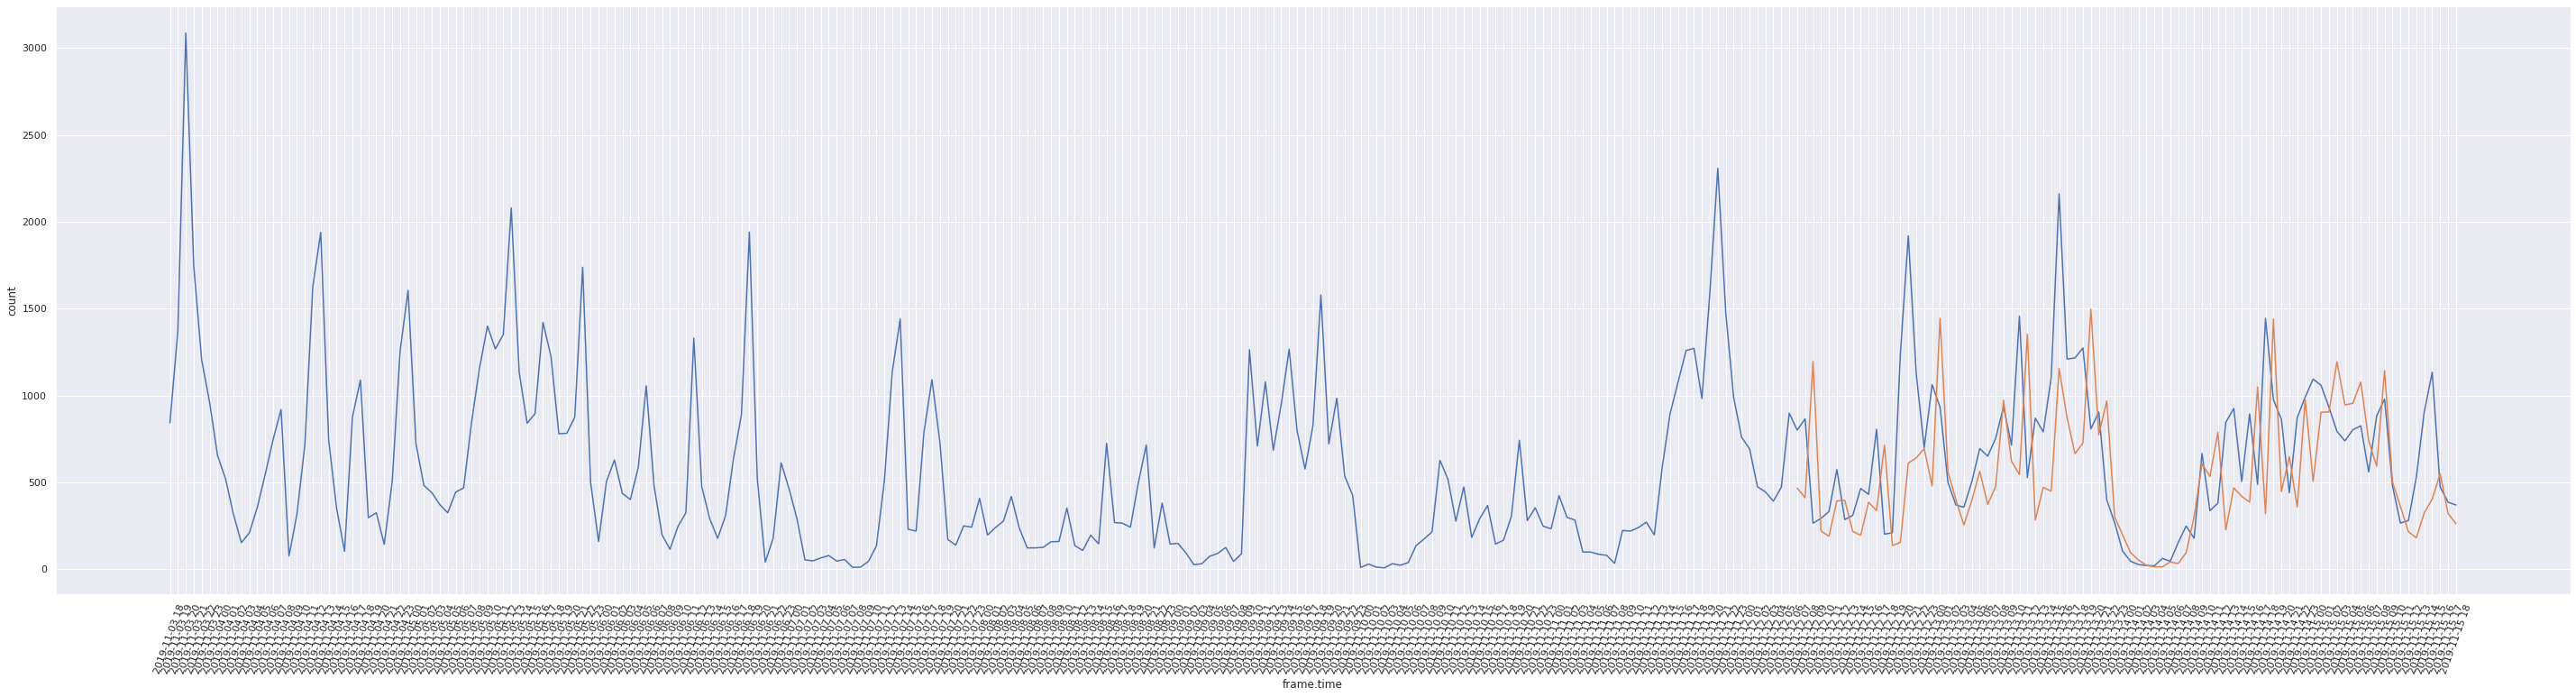

In [935]:
plot_frame_count(ts_df)
plot_frame_count(predicted_ts_df)

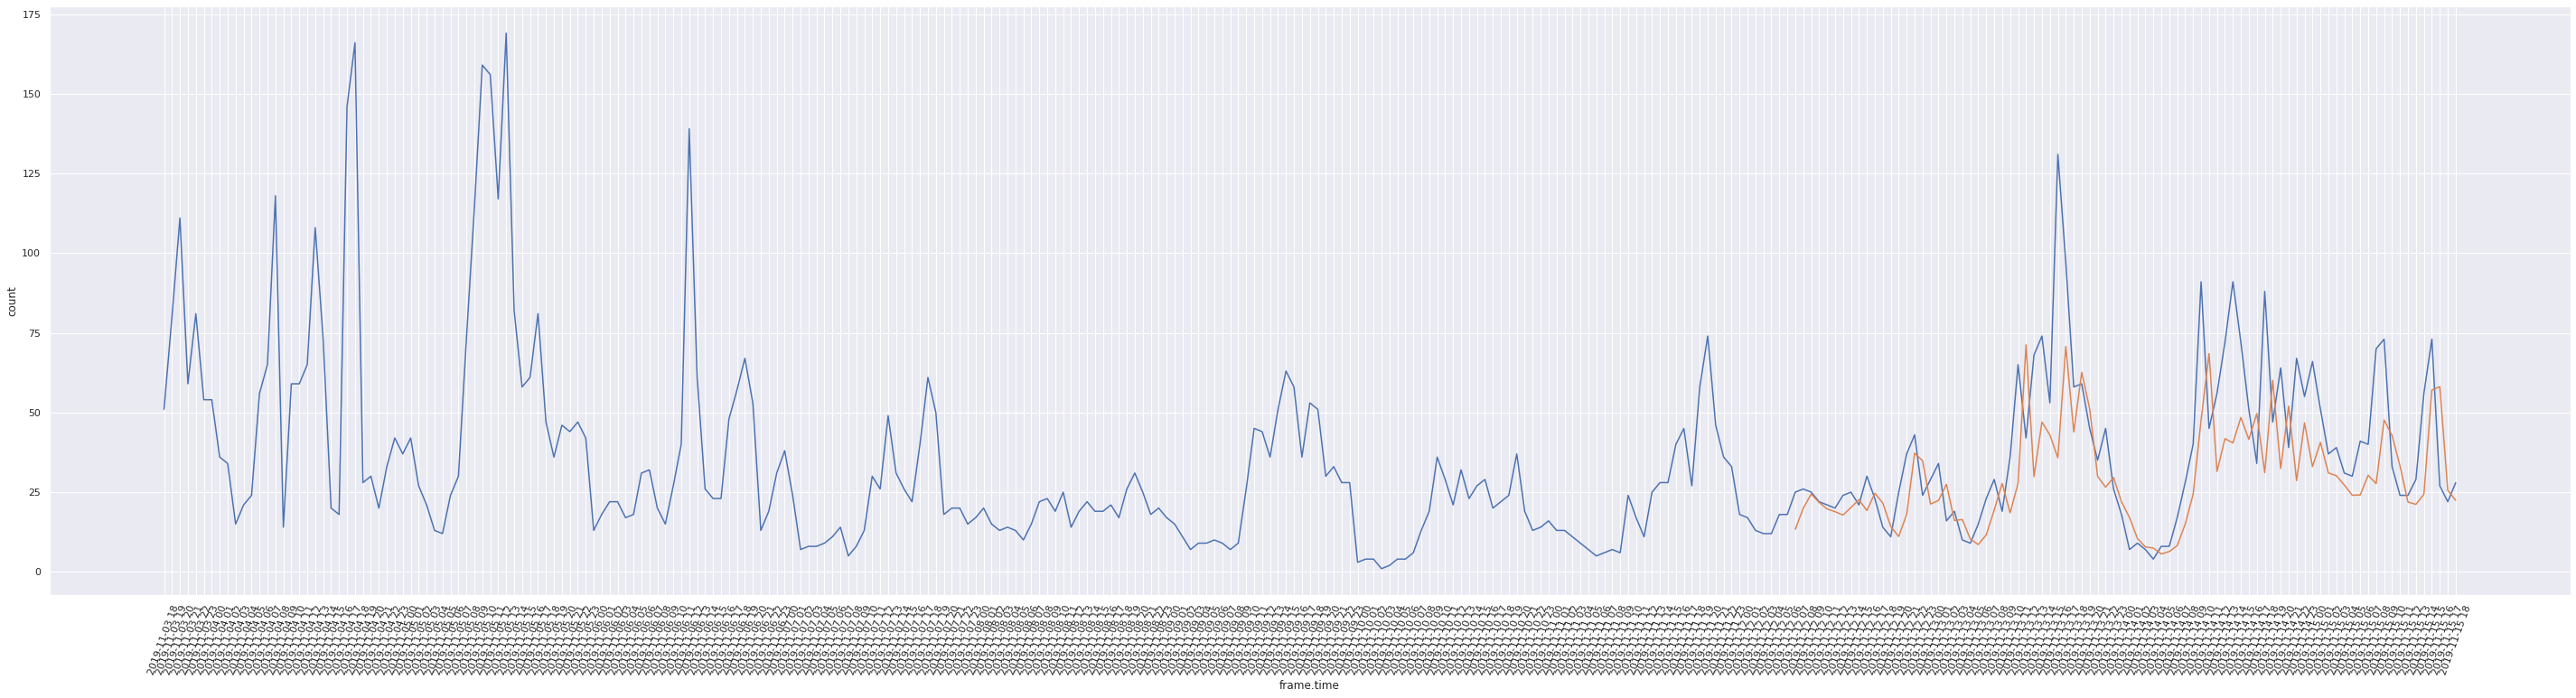

In [936]:
plot_frame_count(umac_df)
plot_frame_count(predicted_umac_df)

## Functional Model 2

### Creating X and Y 

In [937]:
##  We can reuse the X_train and X_test for fc and umac

print(X_train_fc.shape)
print(X_train_umac.shape)
print(y_train_busyness.shape)

(202, 3, 34)
(202, 3, 1)
(202,)


In [938]:
##  define input
visible1 = Input(shape=(n_steps_fc, n_features_fc))
##  first interpretation model 
hidden1 = LSTM(250, activation='relu', return_sequences=True, dropout=0.12)(visible1)
hidden2 = LSTM(250, activation='relu', return_sequences=True)(hidden1)
hidden3 = LSTM(250, activation='relu')(hidden2)
frame_count = Dense(1)(hidden3)
##  define output
frame_count_model = Model(visible1, frame_count)

##  define input
visible2 = Input(shape=(n_steps_umac, n_features_umac))
##  second interpretation  model
hidden4 = LSTM(200, activation='relu', return_sequences=True, dropout=0.2)(visible2)
hidden5 = LSTM(200, activation='relu', return_sequences=True)(hidden4)
hidden6 = LSTM(200, activation='relu')(hidden5)
umac_count = Dense(1)(hidden6)
umac_count_model = Model(visible2, umac_count)

merge = concatenate([frame_count, umac_count])
hidden7 = Dense(512)(merge)
hidden8 = Dense(256)(hidden7)
hidden9 = Dense(256)(hidden8)
busyness = Dense(1)(hidden9)

model = Model(inputs=[visible1, visible2], outputs=busyness)
print(model.summary())
model.compile(optimizer='adam', loss='mse')

Model: "model_144"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          (None, 3, 34)        0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          (None, 3, 1)         0                                            
__________________________________________________________________________________________________
lstm_139 (LSTM)                 (None, 3, 250)       285000      input_107[0][0]                  
__________________________________________________________________________________________________
lstm_142 (LSTM)                 (None, 3, 200)       161600      input_108[0][0]                  
__________________________________________________________________________________________

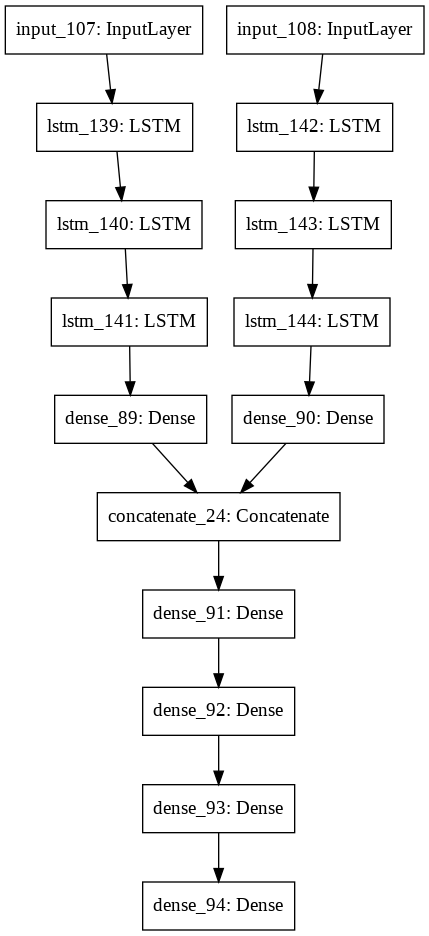

In [939]:
plot_model(model)

In [940]:
model.fit([X_train_fc, X_train_umac],[y_train_busyness], epochs=200, verbose=1, shuffle=False)

Epoch 1/200
202/202 [==============================] - 36s 176ms/step - loss: 5.9604
Epoch 2/200
202/202 [==============================] - 0s 2ms/step - loss: 0.4936
Epoch 3/200
202/202 [==============================] - 0s 2ms/step - loss: 0.1480
Epoch 4/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0973
Epoch 5/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 6/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0161
Epoch 7/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0186
Epoch 8/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0122
Epoch 9/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 10/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0097
Epoch 11/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 12/200
202/202 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 13/2

In [0]:
y_predict_busyness = model.predict([X_test_fc, X_test_umac], verbose=2)

In [942]:
y_predict_busyness[70:83]

array([[0.22195813],
       [0.20981282],
       [0.17343655],
       [0.17446181],
       [0.20186013],
       [0.1819362 ],
       [0.29308692],
       [0.28622106],
       [0.14627036],
       [0.10243127],
       [0.08489744],
       [0.15082367],
       [0.25214905]], dtype=float32)

In [943]:
busyness_df

,frame.time,frame.count.normalized,umac.count.normalized,frame.count,umac.count,count
1,2019-11-03 18,0.271192,0.297619,842,51,0.276477
2,2019-11-03 19,0.442351,0.470238,1369,80,0.447929
3,2019-11-03 20,1.000000,0.654762,3086,111,0.723810
4,2019-11-03 21,0.565119,0.345238,1747,59,0.389214
5,2019-11-03 22,0.388763,0.476190,1204,81,0.406248
...,...,...,...,...,...,...
285,2019-11-15 14,0.291653,0.327381,905,56,0.298799
286,2019-11-15 15,0.365703,0.428571,1133,73,0.378277
287,2019-11-15 16,0.151348,0.154762,473,27,0.152031
288,2019-11-15 17,0.122767,0.125000,385,22,0.123214


In [944]:
results = model.evaluate([X_test_fc, X_test_umac], y_test_busyness[3:87], batch_size=16)
print(results)

84/84 [==============================] - 14s 166ms/step
0.014884086059672492


In [945]:
predicted_rows = y_predict_busyness.shape[0]
predicted_busyness_df = busyness_df.iloc[-predicted_rows:]
predicted_busyness_df['count'] = y_predict_busyness

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


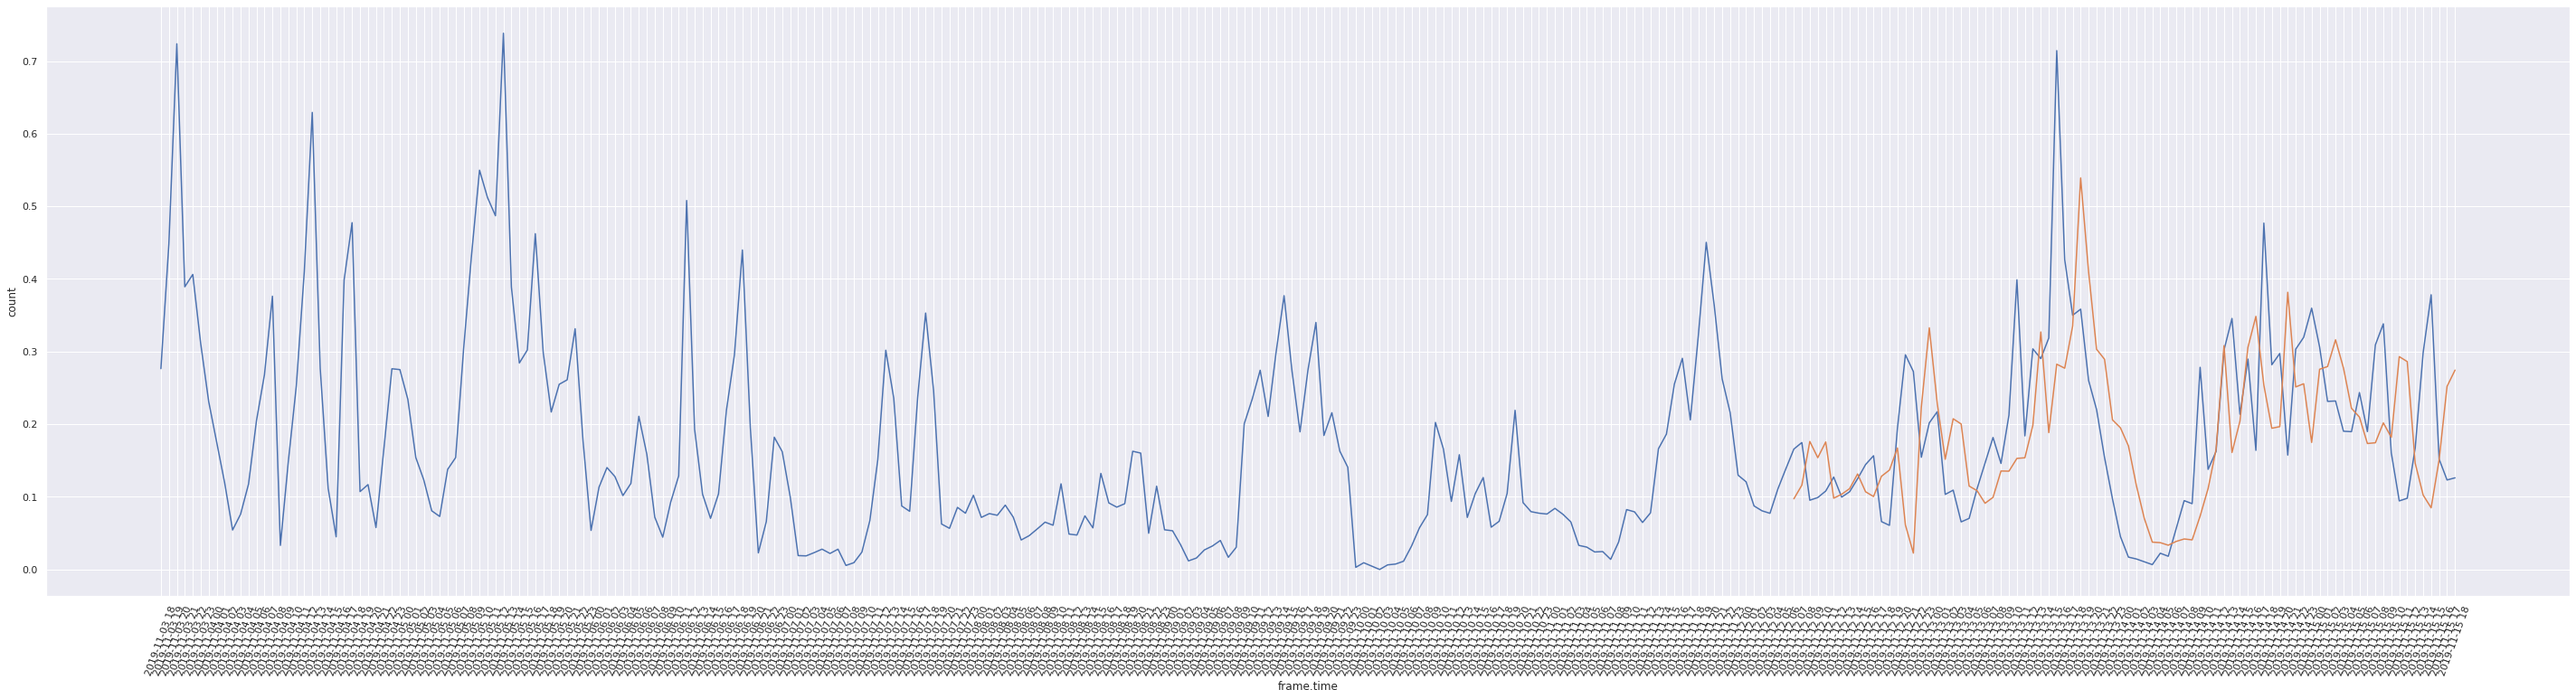

In [946]:
plot_frame_count(busyness_df)
plot_frame_count(predicted_busyness_df)

## Functional Model 3

The first model separately calculates frame count and umac count. 

The second model naively sends in frame count and umac count expecting it to predict busyness given the y_train. The output is unimpressive. 

The goal is train a third model which is able to accurate in predicting busyness as well



### Build First Model

In [125]:
##  first model 
fc_in = Input(shape=(n_steps_fc, n_features_fc), name='fc_in')
hidden1 = LSTM(200, activation='relu', return_sequences=True, name="hidden_1")(fc_in)
hidden2 = LSTM(200, activation='relu', return_sequences=True,name="hidden_2")(hidden1)
hidden3 = LSTM(200, activation='relu',name="hidden_3")(hidden2)
fc_out = Dense(1, name="fc_out")(hidden3)

fc_model = Model(inputs=fc_in, outputs=fc_out)
fc_model.name = "fc_model"

print(fc_model.summary())
fc_model.compile(optimizer='adam', loss='mse')

Model: "fc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_in (InputLayer)           (None, 3, 34)             0         
_________________________________________________________________
hidden_1 (LSTM)              (None, 3, 200)            188000    
_________________________________________________________________
hidden_2 (LSTM)              (None, 3, 200)            320800    
_________________________________________________________________
hidden_3 (LSTM)              (None, 200)               320800    
_________________________________________________________________
fc_out (Dense)               (None, 1)                 201       
Total params: 829,801
Trainable params: 829,801
Non-trainable params: 0
_________________________________________________________________
None


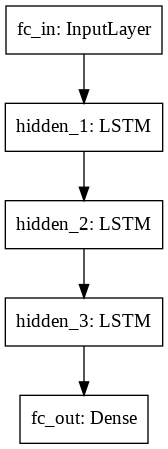

In [126]:
plot_model(fc_model)

### Train First Model

In [127]:
history = fc_model.fit(X_train_fc, y_train_fc, epochs=200, verbose=1, validation_data=(X_test_fc, y_test_fc),shuffle=False)

Train on 202 samples, validate on 84 samples
Epoch 1/200
202/202 [==============================] - 4s 21ms/step - loss: 493837.4295 - val_loss: 512788.8929
Epoch 2/200
202/202 [==============================] - 0s 764us/step - loss: 346731.9641 - val_loss: 180535.4461
Epoch 3/200
202/202 [==============================] - 0s 780us/step - loss: 236577.3106 - val_loss: 158574.8951
Epoch 4/200
202/202 [==============================] - 0s 797us/step - loss: 189152.1275 - val_loss: 137132.0986
Epoch 5/200
202/202 [==============================] - 0s 823us/step - loss: 160674.5159 - val_loss: 135545.8151
Epoch 6/200
202/202 [==============================] - 0s 889us/step - loss: 151159.8267 - val_loss: 130263.9070
Epoch 7/200
202/202 [==============================] - 0s 769us/step - loss: 142993.8284 - val_loss: 132990.6306
Epoch 8/200
202/202 [==============================] - 0s 782us/step - loss: 132942.5744 - val_loss: 137304.8216
Epoch 9/200
202/202 [==============================]

dict_keys(['val_loss', 'loss'])


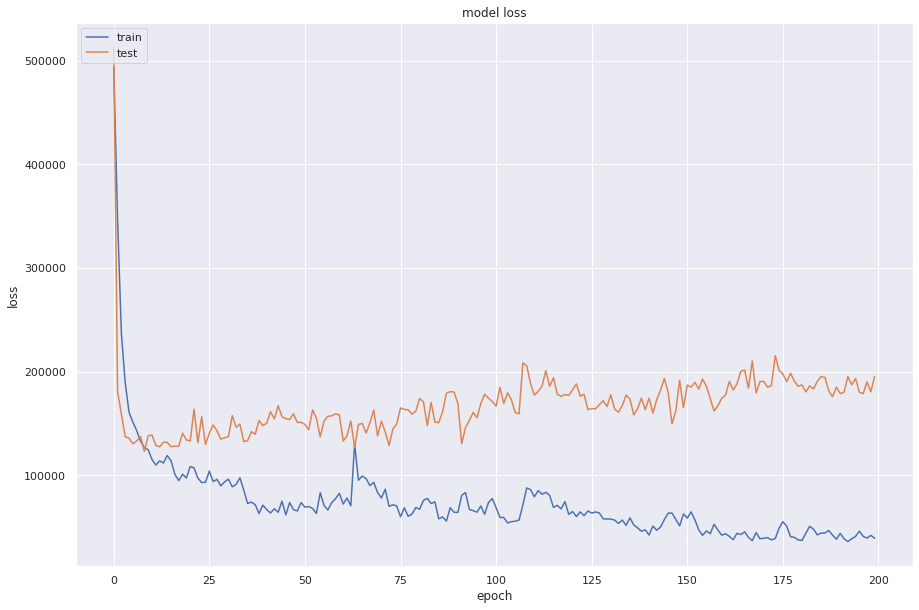

In [128]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [130]:
results = fc_model.evaluate(X_test_fc, y_test_fc, batch_size=16)
print(results)

84/84 [==============================] - 0s 670us/step
195217.19791666666


### Second Model

In [131]:
##  second model
umac_in = Input(shape=(n_steps_umac, n_features_umac), name="umac_in")
hidden4 = LSTM(200, activation='relu', return_sequences=True, dropout=0.1, name="hidden_1")(umac_in)
hidden5 = LSTM(200, activation='relu', return_sequences=True, name="hidden_2")(hidden4)
hidden6 = LSTM(200, activation='relu', name="hidden_3")(hidden5)
umac_out = Dense(1, name="umac_out")(hidden6)

umac_model = Model(umac_in, umac_out)
umac_model.name = "umac_model"
print(umac_model.summary())
umac_model.compile(optimizer='adam', loss='mse')

Model: "umac_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
umac_in (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
hidden_1 (LSTM)              (None, 3, 200)            161600    
_________________________________________________________________
hidden_2 (LSTM)              (None, 3, 200)            320800    
_________________________________________________________________
hidden_3 (LSTM)              (None, 200)               320800    
_________________________________________________________________
umac_out (Dense)             (None, 1)                 201       
Total params: 803,401
Trainable params: 803,401
Non-trainable params: 0
_________________________________________________________________
None


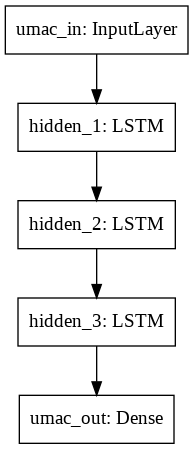

In [132]:
plot_model(umac_model)

In [133]:
history = umac_model.fit(X_train_umac, y_train_umac, epochs=200, verbose=1, validation_data=(X_test_umac, y_test_umac), shuffle=False)

Train on 202 samples, validate on 84 samples
Epoch 1/200
202/202 [==============================] - 5s 24ms/step - loss: 1977.4940 - val_loss: 1692.5003
Epoch 2/200
202/202 [==============================] - 0s 800us/step - loss: 1526.4794 - val_loss: 1019.1537
Epoch 3/200
202/202 [==============================] - 0s 783us/step - loss: 1642.7679 - val_loss: 1413.0613
Epoch 4/200
202/202 [==============================] - 0s 806us/step - loss: 1367.2359 - val_loss: 1332.0758
Epoch 5/200
202/202 [==============================] - 0s 806us/step - loss: 1375.6254 - val_loss: 905.9906
Epoch 6/200
202/202 [==============================] - 0s 992us/step - loss: 945.3862 - val_loss: 482.8486
Epoch 7/200
202/202 [==============================] - 0s 849us/step - loss: 939.9763 - val_loss: 564.4878
Epoch 8/200
202/202 [==============================] - 0s 785us/step - loss: 912.1578 - val_loss: 496.9165
Epoch 9/200
202/202 [==============================] - 0s 757us/step - loss: 755.0888 - val

dict_keys(['val_loss', 'loss'])


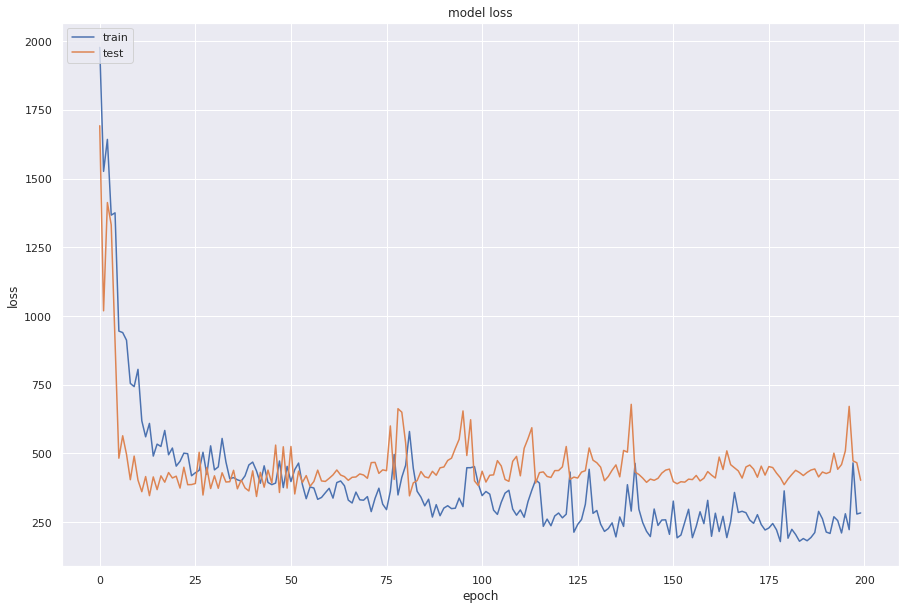

In [134]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [71]:
results = umac_model.evaluate(X_test_umac, y_test_umac, batch_size=16)
print(results)

84/84 [==============================] - 0s 839us/step
494.82133919852123


### Third Model

In [135]:
##  third model 
predicted_frame = Input(shape=(None,1), name="predicted_frame")
predicted_umac = Input(shape=(None,1), name="predicted_umac")
merge = concatenate([predicted_frame, predicted_umac], name="merged")

hidden7 = Dense(256, name="hidden_1")(merge)
hidden8 = Dense(256, name="hidden_2")(hidden7)
busyness_out = Dense(1, name="busyness_out")(hidden8)

busyness_model = Model([predicted_frame, predicted_umac], busyness_out)
busyness_model.name = "busyness_model"

print(busyness_model.summary())
busyness_model.compile(optimizer='adam', loss='mse')

Model: "busyness_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
predicted_frame (InputLayer)    (None, None, 1)      0                                            
__________________________________________________________________________________________________
predicted_umac (InputLayer)     (None, None, 1)      0                                            
__________________________________________________________________________________________________
merged (Concatenate)            (None, None, 2)      0           predicted_frame[0][0]            
                                                                 predicted_umac[0][0]             
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, None, 256)    768         merged[0][0]        

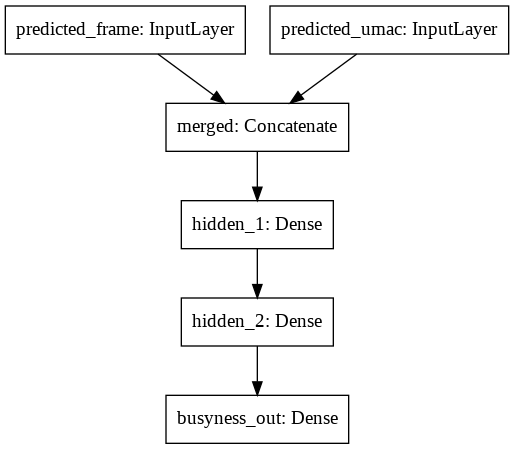

In [136]:
plot_model(busyness_model)

In [0]:
X_train_busyness_frames = np.array(X_train_busyness['frame.count'])
X_train_busyness_umacs = np.array(X_train_busyness['umac.count'])

X_test_busyness_frames = np.array(X_test_busyness['frame.count'])
X_test_busyness_umacs = np.array(X_test_busyness['umac.count'])

y_train_busyness = np.array(y_train_busyness)

y_test_busyness = np.array(y_test_busyness)

#####

X_train_busyness_frames = X_train_busyness_frames.reshape((1, X_train_busyness['frame.count'].shape[0], 1))
X_train_busyness_umacs = X_train_busyness_umacs.reshape((1, X_train_busyness['umac.count'].shape[0], 1))

X_test_busyness_frames = X_test_busyness_frames.reshape((1, X_test_busyness['frame.count'].shape[0], 1))
X_test_busyness_umacs = X_test_busyness_umacs.reshape((1, X_test_busyness['umac.count'].shape[0], 1))


y_train_busyness = y_train_busyness.reshape(1,y_train_busyness.shape[0],1)
y_test_busyness = y_test_busyness.reshape(1,y_test_busyness.shape[0],1)

In [138]:
print(X_train_busyness_frames.shape)
print(X_train_busyness_umacs.shape)
print(y_train_busyness.shape)

print(X_test_busyness_frames.shape)
print(X_test_busyness_umacs.shape)
print(y_test_busyness.shape)

(1, 202, 1)
(1, 202, 1)
(1, 202, 1)
(1, 87, 1)
(1, 87, 1)
(1, 87, 1)


In [139]:
history = busyness_model.fit([X_train_busyness_frames,X_train_busyness_umacs], y_train_busyness, validation_data=([X_test_busyness_frames, X_test_busyness_umacs],y_test_busyness), epochs=225, verbose=1, shuffle=False)

Train on 1 samples, validate on 1 samples
Epoch 1/225
1/1 [==============================] - 4s 4s/step - loss: 8964.4619 - val_loss: 48705.9883
Epoch 2/225
1/1 [==============================] - 0s 9ms/step - loss: 44605.5586 - val_loss: 8349.0166
Epoch 3/225
1/1 [==============================] - 0s 7ms/step - loss: 7636.8711 - val_loss: 5209.6646
Epoch 4/225
1/1 [==============================] - 0s 7ms/step - loss: 4802.3125 - val_loss: 22783.0352
Epoch 5/225
1/1 [==============================] - 0s 8ms/step - loss: 20935.8340 - val_loss: 15766.0039
Epoch 6/225
1/1 [==============================] - 0s 7ms/step - loss: 14493.8242 - val_loss: 2031.0435
Epoch 7/225
1/1 [==============================] - 0s 8ms/step - loss: 1878.6150 - val_loss: 2007.7477
Epoch 8/225
1/1 [==============================] - 0s 8ms/step - loss: 1835.0381 - val_loss: 10558.5283
Epoch 9/225
1/1 [==============================] - 0s 7ms/step - loss: 9661.8359 - val_loss: 11935.8164
Epoch 10/225
1/1 [======

dict_keys(['val_loss', 'loss'])


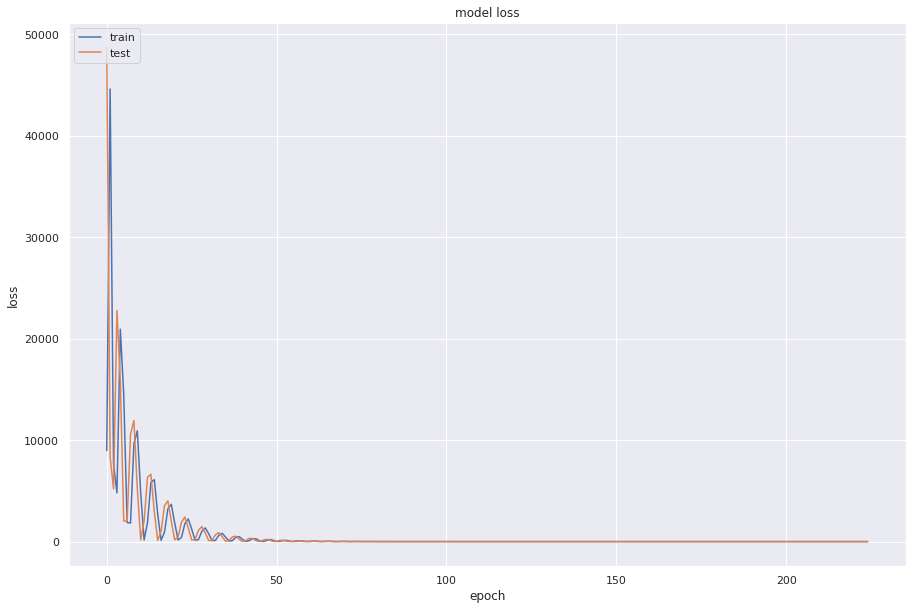

In [140]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

plt.figure(figsize=(15,10))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
y_predict_busyness = busyness_model.predict([X_test_busyness_frames, X_test_busyness_umacs], verbose=2)

In [0]:
y_predict_busyness = y_predict_busyness.reshape(y_predict_busyness.shape[1])

In [79]:
predicted_rows = y_predict_busyness.shape[0]
predicted_busyness_df = busyness_df.iloc[-predicted_rows:]
predicted_busyness_df['count'] = y_predict_busyness

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
y_predict_busyness[0:5]

array([0.09299061, 0.11840031, 0.18230413, 0.18332075, 0.19529699],
      dtype=float32)

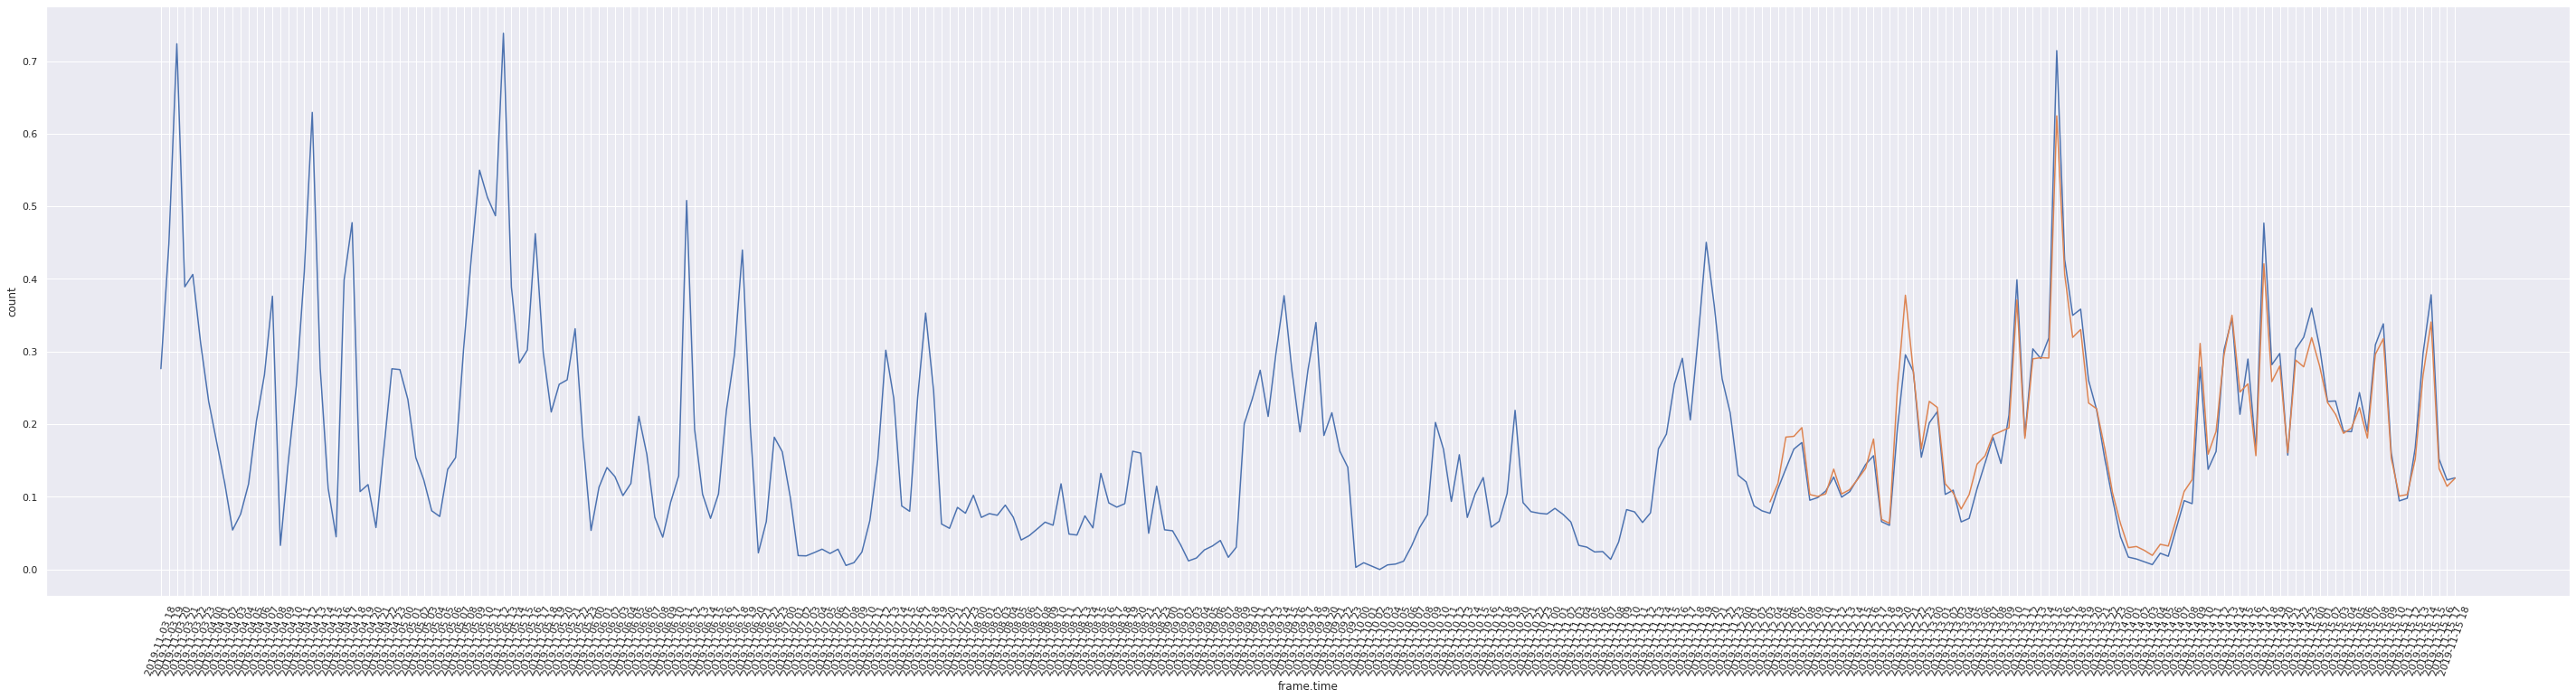

In [81]:
plot_frame_count(busyness_df)
plot_frame_count(predicted_busyness_df)

### Overview Model

In [82]:
##  encapsulating model 
frames = Input(shape=(n_steps_fc, n_features_fc))
umacs = Input(shape=(n_steps_umac, n_features_umac))

out_frame = fc_model(frames)
out_umac = umac_model(umacs)



fc_model.trainable = False
umac_model.trainable = False

out_busyness = busyness_model([out_frame, out_umac])
busyness_model.trainable = False

overview_model = Model(inputs=[frames, umacs], outputs=out_busyness)
print(overview_model.summary())
overview_model.compile(optimizer='adam', loss='mse')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 34)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3, 1)         0                                            
__________________________________________________________________________________________________
fc_model (Model)                (None, 1)            1087781     input_1[0][0]                    
__________________________________________________________________________________________________
umac_model (Model)              (None, 1)            803401      input_2[0][0]                    
____________________________________________________________________________________________

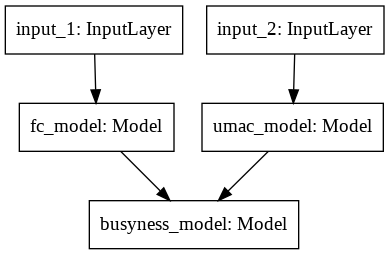

In [83]:
plot_model(overview_model)

In [0]:
y_predict_busyness = overview_model.predict([X_test_fc, X_test_umac], verbose=2)

In [106]:
train_mse = overview_model.evaluate([X_train_fc, X_train_umac], y_train_busyness, batch_size=16)
test_mse = overview_model.evaluate([X_test_fc, X_test_umac], y_test_busyness[3:87], batch_size=16)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

84/84 [==============================] - 0s 1ms/step
Train: 0.020, Test: 0.013


In [968]:
predicted_rows = y_predict_busyness.shape[0]
final_predicted_busyness_df = busyness_df.iloc[-predicted_rows:]
final_predicted_busyness_df['count'] = y_predict_busyness

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


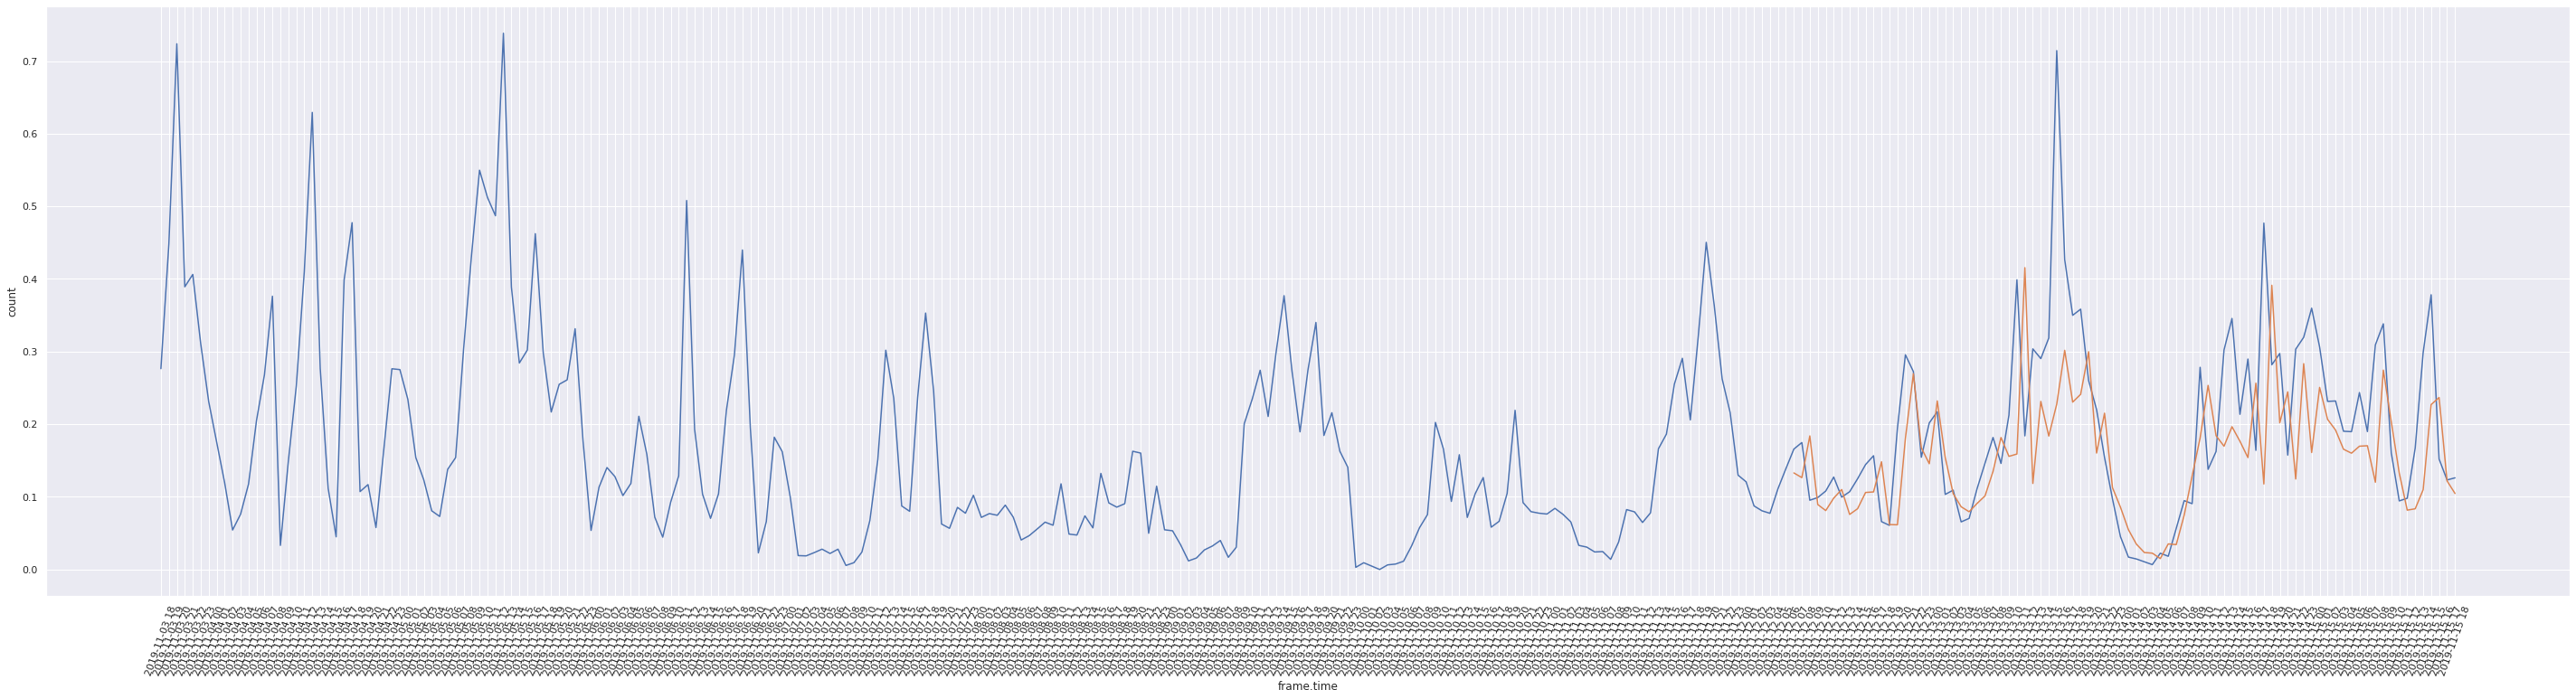

In [969]:
plot_frame_count(busyness_df)
# plot_frame_count(predicted_busyness_df)
plot_frame_count(final_predicted_busyness_df)

In [970]:
final_predicted_busyness_df.tail()

,frame.time,frame.count.normalized,umac.count.normalized,frame.count,umac.count,count
285,2019-11-15 14,0.291653,0.327381,905,56,0.109843
286,2019-11-15 15,0.365703,0.428571,1133,73,0.227062
287,2019-11-15 16,0.151348,0.154762,473,27,0.236758
288,2019-11-15 17,0.122767,0.125000,385,22,0.121927
289,2019-11-15 18,0.117571,0.160714,369,28,0.104625


In [971]:
 busyness_df.tail()

,frame.time,frame.count.normalized,umac.count.normalized,frame.count,umac.count,count
285,2019-11-15 14,0.291653,0.327381,905,56,0.298799
286,2019-11-15 15,0.365703,0.428571,1133,73,0.378277
287,2019-11-15 16,0.151348,0.154762,473,27,0.152031
288,2019-11-15 17,0.122767,0.125000,385,22,0.123214
289,2019-11-15 18,0.117571,0.160714,369,28,0.126199


In [974]:
export_df = busyness_df[['frame.time']]
export_df['frame.time'] = pd.to_datetime(export_df['frame.time'])
export_df['dayOfWeek'] =  export_df['frame.time'].dt.weekday
export_df['hourOfDay'] =  export_df['frame.time'].dt.hour
export_df['actualBusyness'] = busyness_df['count']
export_df = export_df.merge(final_predicted_busyness_df['count'], left_index=True, right_index=True, how='left')
export_df = export_df.fillna(0)
export_df.rename(columns = {'count':'predictedBusyness'}, inplace = True) 

export_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,frame.time,dayOfWeek,hourOfDay,actualBusyness,predictedBusyness
1,2019-11-03 18:00:00,6,18,0.276477,0.0
2,2019-11-03 19:00:00,6,19,0.447929,0.0
3,2019-11-03 20:00:00,6,20,0.723810,0.0
4,2019-11-03 21:00:00,6,21,0.389214,0.0
5,2019-11-03 22:00:00,6,22,0.406248,0.0


In [0]:
export_df.to_csv('db_dat.csv') 